- Use case of the current script
    - There are about 250 participants for an academic event which offers several courses
    - Each participant has preferences for some of these courses
    - The script should assign the participants to the courses so most of the participants can attend to the courses of their preference    
- Workflow of this script
    1. Try Genetic Algorithms to solve the problem
    2. Optimize parameters of this algorithm using Bayesian Optimization
    3. Compare previous results with a naive algorithm to sort the participants according to their preferences

# Import libs and define basic parameters

In [2]:
from random import choices
import random as rd
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict

In [3]:
# set parameters
no_participants = 250  # later the number of columns -1 of the input excel
no_courses = 18
participant_limit_per_course = 20
low_p_weight = 1
high_p_weight = 1
mutation_probability = 0.5
no_mutation_replacements = int(no_participants * 0.5 * 2)
population_size = 6

In [4]:
# optimized parameters
# |   iter    |  target   | high_p... | mutati... | no_mut... | popula... |
# | 14        | 2.028     | 1.329     | 0.4686    | 41.41     | 17.98     |
high_p_weight = 1
mutation_probability = 0.4686
no_mutation_replacements = 41
population_size = 18

# Functions

## Generating genoms

In [5]:
# Genome = potential assignments to the courses for each particpipant
def generate_genome_col(length=no_participants, options=no_courses, low_p=low_p_weight, high_p=high_p_weight):
  # length =  no_courses
  # options = no_participants
  weights = [rd.randint(low_p, high_p) for i in range(1, options + 1)]
  return choices(range(1, options + 1), weights=weights, k=length)
  # plt.hist(genome_rand)

In [6]:
# generate genomes that does not contain vaulues occuring for the same participant (row) and prio (col) in the lists of prim_lists
def generate_genome_col_other_than(prim_lists, length=no_participants, options=no_courses, low_p=low_p_weight, high_p=high_p_weight):
  # length =  no_courses
  # options = no_participants
  weights = [rd.randint(low_p, high_p) for i in range(1, options + 1)]
    # create random weights for the genereation of random numbers in range of options
  genome = choices(range(1, options + 1), weights=weights, k=length)
  
  for i, assignment in enumerate(genome):
    prim_assignments = [prim_list[i] for prim_list in prim_lists]
    while assignment in prim_assignments:
      genome[i] = choices(range(1, options + 1))[0]
      assignment = genome[i]
  return genome
  # plt.hist(genome_rand)

In [7]:
def generate_genome(length=no_participants, options=no_courses, low_p=low_p_weight, high_p=high_p_weight):
  day1 = generate_genome_col(length, options, low_p, high_p)
  return pd.DataFrame(data={
    "Day1":day1,
    "Day2":generate_genome_col_other_than([day1], length, options, low_p, high_p)
  })

## Generate populations

In [8]:
def generate_population(size, genome_length=no_participants, options=no_courses, low_p=low_p_weight, high_p=high_p_weight):
  return [generate_genome(genome_length, options, low_p, high_p) for _ in range(size)]

## Create test data set

In [9]:
test_choices_df = pd.read_csv('test_choices_df.csv')
test_choices_df = test_choices_df.iloc[:,1:5]
test_choices_df

,prio1,prio2,prio3,prio4
0,7,3,10,6
1,8,18,16,14
2,10,17,14,9
3,6,4,18,13
4,3,15,16,1
...,...,...,...,...
245,14,9,4,6
246,9,15,18,5
247,15,16,3,17
248,10,1,9,12


## Fitness

In [10]:
# function returning integer (range: 0 to len(genome) * 4; 0 is optimal fit; -1 is invalid)
def fitness(genome, choices_df=test_choices_df, parti_limit_list=[participant_limit_per_course]*no_courses):
  # choices_df = prios of the participants
  # genome = potential assignments that has to be reviewed for fitness
  # course_limits = list of participant limits of courses (with length = number of courses)
  
  if len(genome["Day1"]) != len(choices_df["prio1"]):
    print(len(genome["Day1"]), len(choices_df["prio1"]))
    raise ValueError("genome should have same number of rows as choices_df")
  
  fit = 0
  for day in ["Day1", "Day2"]:
    for participant, assignment in enumerate(genome[day]):
      if assignment == choices_df["prio1"][participant]:
        fit += 5
      elif assignment == choices_df["prio2"][participant]:
        fit += 4
      elif assignment == choices_df["prio3"][participant]:
        fit += 3
      elif assignment == choices_df["prio4"][participant]:
        fit += 2
      else:
        fit += 1

  # check if paricipant limits per course are violated
  day1_parti_limit_violation = True in [dict(Counter(genome["Day1"]))[course] > parti_limit_list[i] for i, course in enumerate(dict(Counter(genome["Day1"])))]
  day2_parti_limit_violation = True in [dict(Counter(genome["Day2"]))[course] > parti_limit_list[i] for i, course in enumerate(dict(Counter(genome["Day2"])))]
  if day1_parti_limit_violation or day2_parti_limit_violation:
    fit = 0  # invalid
    
  return fit

## Selection Function

In [11]:
# return two genomes that are likly to have a good fit
def selection_pair(population, fitness_func):
  
  # check if all solutions are invalid (fit = 0)
  weights = [fitness_func(genome) for genome in population]  # weights for choices function below
    # better fit --> higher p to be chosen
  if False not in [i == 0 for i in weights]:  # True if every element of weights is 0
    # the higher the number of the most assigned course per genome the lower the weight should be
    # --> more even distributet assignments should have higher weights
    weights = []
    for genome in population:
      participants_per_course_day1 = [dict(Counter(genome["Day1"]))[course] for i, course in enumerate(dict(Counter(genome["Day1"])))]
      participants_per_course_day2 = [dict(Counter(genome["Day2"]))[course] for i, course in enumerate(dict(Counter(genome["Day2"])))]
      most_participants_per_course = max(participants_per_course_day1 + participants_per_course_day2)
      weights.append(1/(most_participants_per_course^2))
  
  return choices(
    population=population,
    weights=weights,
    k=2
  )

## Single point crossover

In [12]:
def single_point_crossover(genome1, genome2):
  if len(genome1["Day1"]) != len(genome2["Day1"]):
    raise ValueError("Both inputed genomes must have number of rows")
  
  if len(genome1["Day1"]) < 2:
    return genome1, genome2
  
  p = rd.randint(1, len(genome1["Day1"]) - 1)
  return pd.concat([genome1.iloc[0:p], genome2.iloc[p:]]), pd.concat([genome2.iloc[0:p], genome1.iloc[p:]])
    # returns 2 new genomes where new genome1 containts 0:p rows of old genome1 and p: rows of old genome to and same for new genome 2

## Mutation

In [13]:
def mutation(
  genome, no_replacements=no_mutation_replacements,
  propability=mutation_probability, no_possibilities=no_courses
):
  # replace n=no_replacements values by propability of 50% by another value of replacement_list
  for _ in range(no_replacements):
    # choose random index
    index = rd.randrange(len(genome["Day1"]))
    col = rd.randrange(len(genome.iloc[0]))
    
    # generate list of all courses without the one that is present in genome[col, index] and same of other col
    replacement_list = list(range(1, no_possibilities + 1))
    replacement_list.remove(genome.iloc[index, col])
    replacement_list.remove(genome.iloc[index, 0 if col == 1 else 1])
    
    # replace the value by propability of 50%
    genome.iloc[index, col] = genome.iloc[index, col] if rd.random() > propability else rd.choice(replacement_list)
    
  return genome

## Run evolution

In [14]:
def run_evolotuion(
  population_func,
  fitness_func,
  selection_func,
  crossover_func,
  mutation_func,
  gernation_limit,
#  fitness_limit=(5 + 4)/2,
  population_size=population_size
):
  
  # generate first fpopulation
  population = population_func(population_size)
  
  for generation_no in range(gernation_limit):
    
    # sort population for fitness (best fitting first)
    population = sorted(
      population,
      key=lambda genome: fitness_func(genome),
      reverse=True
    )
    print(f"gernation: {generation_no}; fit: {fitness_func(population[0])/no_participants/2} points per participant")
    
#     if fitness_func(population[0]) >= fitness_limit:
#       break
    
    # generate next generation's population by taking two solutions (more fitting = more likely)...
    # ...and use offsprings by mutationg and crossing over
    next_generation = population[0:2]
    
    for j in range(int(len(population) / 2) - 1):
      parents = selection_func(population, fitness_func)
      offspring_a, offspring_b = crossover_func(parents[0], parents[1])
      offspring_a = mutation_func(offspring_a)
      offspring_b = mutation_func(offspring_b)
      next_generation += [offspring_a, offspring_b]
      
    population = next_generation
    
  population = sorted(
    population,
    key=lambda genome: fitness_func(genome),
    reverse=True
  )

  return population, generation_no

## Count how many of wich prio was successfully assigned

In [15]:
def count_prio_hits(assignment_df, choices_df):
  prio1_hits = 0
  prio2_hits = 0
  prio3_hits = 0
  prio4_hits = 0
  no_hits = 0
  for col in range(2):
    for i, course in enumerate(assignment_df.iloc[:, col]):
      if course == choices_df.iloc[i, 0]:
        prio1_hits += 1
      elif course == choices_df.iloc[i, 1]:
        prio2_hits += 1
      elif course == choices_df.iloc[i, 2]:
        prio3_hits += 1
      elif course == choices_df.iloc[i, 3]:
        prio4_hits += 1
      else:
        no_hits += 1
    
  return pd.DataFrame(data={
    'prio1_hits':[prio1_hits],
    'prio2_hits':[prio2_hits],
    'prio3_hits':[prio3_hits],
    'prio4_hits':[prio4_hits],
    'no_hits':[no_hits]
  })

# Run genetic algorithm

In [37]:
# with 2 assignments
best_population, generation_no = run_evolotuion(
  generate_population,
  fitness,
  selection_pair,
  single_point_crossover,
  mutation,
  gernation_limit=1000
)

print(f"number of generations needed: {generation_no}")
print(f"fitness of best solution: {fitness(best_population[0])/no_participants/2} points per participant")
print(f"best solution: {count_prio_hits(best_population[0], test_choices_df)}")

gernation: 0; fit: 1.588 points per participant
gernation: 1; fit: 1.59 points per participant
gernation: 2; fit: 1.592 points per participant
gernation: 3; fit: 1.61 points per participant
gernation: 4; fit: 1.654 points per participant
gernation: 5; fit: 1.654 points per participant
gernation: 6; fit: 1.654 points per participant
gernation: 7; fit: 1.672 points per participant
gernation: 8; fit: 1.672 points per participant
gernation: 9; fit: 1.68 points per participant
gernation: 10; fit: 1.68 points per participant
gernation: 11; fit: 1.714 points per participant
gernation: 12; fit: 1.714 points per participant
gernation: 13; fit: 1.714 points per participant
gernation: 14; fit: 1.714 points per participant
gernation: 15; fit: 1.718 points per participant
gernation: 16; fit: 1.736 points per participant
gernation: 17; fit: 1.744 points per participant
gernation: 18; fit: 1.76 points per participant
gernation: 19; fit: 1.784 points per participant
gernation: 20; fit: 1.784 points pe

KeyboardInterrupt: 

In [275]:
# (without optimized parameters) count how many choices was assigned successfully and calculate back to score for double check
hits_df = count_prio_hits(population[0], test_choices_df)
print(hits_df)
print((hits_df.iloc[0,0]*5 + hits_df.iloc[0,1]*4 + hits_df.iloc[0,2]*3 + hits_df.iloc[0,3]*2 + hits_df.iloc[0,4])/no_participants/2)

   prio1_hits  prio2_hits  prio3_hits  prio4_hits  no_hits
0          53          41          46          40      320
1.934


## Good results (1 assignment)

In [14]:
population, generation_no = run_evolotuion(
  generate_population,
  fitness,
  selection_pair,
  single_point_crossover,
  mutation,
  gernation_limit=10000
)

print(f"number of generations needed: {generation_no}")
print(f"fitness of best solution: {fitness(population[0])}")
print(f"best solution: {population[0]}")

gernation: 0; fit: 501
gernation: 1; fit: 526
gernation: 2; fit: 526
gernation: 3; fit: 526
gernation: 4; fit: 526
gernation: 5; fit: 526
gernation: 6; fit: 527
gernation: 7; fit: 527
gernation: 8; fit: 527
gernation: 9; fit: 555
gernation: 10; fit: 555
gernation: 11; fit: 555
gernation: 12; fit: 555
gernation: 13; fit: 555
gernation: 14; fit: 555
gernation: 15; fit: 555
gernation: 16; fit: 566
gernation: 17; fit: 579
gernation: 18; fit: 579
gernation: 19; fit: 579
gernation: 20; fit: 579
gernation: 21; fit: 592
gernation: 22; fit: 592
gernation: 23; fit: 592
gernation: 24; fit: 592
gernation: 25; fit: 592
gernation: 26; fit: 592
gernation: 27; fit: 592
gernation: 28; fit: 592
gernation: 29; fit: 592
gernation: 30; fit: 610
gernation: 31; fit: 610
gernation: 32; fit: 610
gernation: 33; fit: 610
gernation: 34; fit: 610
gernation: 35; fit: 610
gernation: 36; fit: 610
gernation: 37; fit: 610
gernation: 38; fit: 610
gernation: 39; fit: 610
gernation: 40; fit: 610
gernation: 41; fit: 610
ge

gernation: 335; fit: 668
gernation: 336; fit: 668
gernation: 337; fit: 668
gernation: 338; fit: 668
gernation: 339; fit: 668
gernation: 340; fit: 668
gernation: 341; fit: 668
gernation: 342; fit: 668
gernation: 343; fit: 668
gernation: 344; fit: 668
gernation: 345; fit: 668
gernation: 346; fit: 668
gernation: 347; fit: 668
gernation: 348; fit: 668
gernation: 349; fit: 668
gernation: 350; fit: 668
gernation: 351; fit: 668
gernation: 352; fit: 668
gernation: 353; fit: 668
gernation: 354; fit: 668
gernation: 355; fit: 668
gernation: 356; fit: 668
gernation: 357; fit: 668
gernation: 358; fit: 668
gernation: 359; fit: 668
gernation: 360; fit: 668
gernation: 361; fit: 668
gernation: 362; fit: 668
gernation: 363; fit: 668
gernation: 364; fit: 668
gernation: 365; fit: 668
gernation: 366; fit: 668
gernation: 367; fit: 668
gernation: 368; fit: 668
gernation: 369; fit: 668
gernation: 370; fit: 668
gernation: 371; fit: 668
gernation: 372; fit: 668
gernation: 373; fit: 668
gernation: 374; fit: 668


gernation: 663; fit: 676
gernation: 664; fit: 676
gernation: 665; fit: 676
gernation: 666; fit: 676
gernation: 667; fit: 676
gernation: 668; fit: 676
gernation: 669; fit: 676
gernation: 670; fit: 676
gernation: 671; fit: 676
gernation: 672; fit: 676
gernation: 673; fit: 676
gernation: 674; fit: 676
gernation: 675; fit: 676
gernation: 676; fit: 676
gernation: 677; fit: 676
gernation: 678; fit: 676
gernation: 679; fit: 676
gernation: 680; fit: 676
gernation: 681; fit: 676
gernation: 682; fit: 676
gernation: 683; fit: 676
gernation: 684; fit: 676
gernation: 685; fit: 676
gernation: 686; fit: 676
gernation: 687; fit: 676
gernation: 688; fit: 676
gernation: 689; fit: 676
gernation: 690; fit: 676
gernation: 691; fit: 676
gernation: 692; fit: 676
gernation: 693; fit: 676
gernation: 694; fit: 676
gernation: 695; fit: 676
gernation: 696; fit: 676
gernation: 697; fit: 676
gernation: 698; fit: 676
gernation: 699; fit: 676
gernation: 700; fit: 676
gernation: 701; fit: 676
gernation: 702; fit: 676


gernation: 991; fit: 676
gernation: 992; fit: 676
gernation: 993; fit: 676
gernation: 994; fit: 676
gernation: 995; fit: 676
gernation: 996; fit: 676
gernation: 997; fit: 676
gernation: 998; fit: 676
gernation: 999; fit: 676
gernation: 1000; fit: 676
gernation: 1001; fit: 676
gernation: 1002; fit: 676
gernation: 1003; fit: 676
gernation: 1004; fit: 676
gernation: 1005; fit: 676
gernation: 1006; fit: 676
gernation: 1007; fit: 676
gernation: 1008; fit: 676
gernation: 1009; fit: 676
gernation: 1010; fit: 676
gernation: 1011; fit: 676
gernation: 1012; fit: 676
gernation: 1013; fit: 676
gernation: 1014; fit: 676
gernation: 1015; fit: 676
gernation: 1016; fit: 676
gernation: 1017; fit: 676
gernation: 1018; fit: 676
gernation: 1019; fit: 676
gernation: 1020; fit: 676
gernation: 1021; fit: 676
gernation: 1022; fit: 676
gernation: 1023; fit: 676
gernation: 1024; fit: 676
gernation: 1025; fit: 676
gernation: 1026; fit: 676
gernation: 1027; fit: 676
gernation: 1028; fit: 676
gernation: 1029; fit:

gernation: 1308; fit: 678
gernation: 1309; fit: 678
gernation: 1310; fit: 678
gernation: 1311; fit: 678
gernation: 1312; fit: 678
gernation: 1313; fit: 678
gernation: 1314; fit: 678
gernation: 1315; fit: 678
gernation: 1316; fit: 678
gernation: 1317; fit: 678
gernation: 1318; fit: 678
gernation: 1319; fit: 678
gernation: 1320; fit: 678
gernation: 1321; fit: 678
gernation: 1322; fit: 678
gernation: 1323; fit: 678
gernation: 1324; fit: 678
gernation: 1325; fit: 678
gernation: 1326; fit: 678
gernation: 1327; fit: 678
gernation: 1328; fit: 678
gernation: 1329; fit: 678
gernation: 1330; fit: 678
gernation: 1331; fit: 678
gernation: 1332; fit: 678
gernation: 1333; fit: 678
gernation: 1334; fit: 678
gernation: 1335; fit: 678
gernation: 1336; fit: 678
gernation: 1337; fit: 678
gernation: 1338; fit: 678
gernation: 1339; fit: 678
gernation: 1340; fit: 678
gernation: 1341; fit: 678
gernation: 1342; fit: 678
gernation: 1343; fit: 678
gernation: 1344; fit: 678
gernation: 1345; fit: 678
gernation: 1

gernation: 1625; fit: 689
gernation: 1626; fit: 689
gernation: 1627; fit: 689
gernation: 1628; fit: 689
gernation: 1629; fit: 689
gernation: 1630; fit: 689
gernation: 1631; fit: 689
gernation: 1632; fit: 689
gernation: 1633; fit: 689
gernation: 1634; fit: 689
gernation: 1635; fit: 689
gernation: 1636; fit: 689
gernation: 1637; fit: 689
gernation: 1638; fit: 689
gernation: 1639; fit: 689
gernation: 1640; fit: 689
gernation: 1641; fit: 689
gernation: 1642; fit: 689
gernation: 1643; fit: 689
gernation: 1644; fit: 689
gernation: 1645; fit: 689
gernation: 1646; fit: 689
gernation: 1647; fit: 689
gernation: 1648; fit: 689
gernation: 1649; fit: 689
gernation: 1650; fit: 689
gernation: 1651; fit: 689
gernation: 1652; fit: 689
gernation: 1653; fit: 689
gernation: 1654; fit: 689
gernation: 1655; fit: 689
gernation: 1656; fit: 689
gernation: 1657; fit: 689
gernation: 1658; fit: 689
gernation: 1659; fit: 689
gernation: 1660; fit: 689
gernation: 1661; fit: 689
gernation: 1662; fit: 689
gernation: 1

gernation: 1943; fit: 710
gernation: 1944; fit: 710
gernation: 1945; fit: 710
gernation: 1946; fit: 710
gernation: 1947; fit: 710
gernation: 1948; fit: 710
gernation: 1949; fit: 710
gernation: 1950; fit: 710
gernation: 1951; fit: 710
gernation: 1952; fit: 710
gernation: 1953; fit: 710
gernation: 1954; fit: 710
gernation: 1955; fit: 710
gernation: 1956; fit: 710
gernation: 1957; fit: 710
gernation: 1958; fit: 710
gernation: 1959; fit: 710
gernation: 1960; fit: 710
gernation: 1961; fit: 710
gernation: 1962; fit: 710
gernation: 1963; fit: 710
gernation: 1964; fit: 710
gernation: 1965; fit: 710
gernation: 1966; fit: 710
gernation: 1967; fit: 710
gernation: 1968; fit: 710
gernation: 1969; fit: 710
gernation: 1970; fit: 710
gernation: 1971; fit: 710
gernation: 1972; fit: 710
gernation: 1973; fit: 710
gernation: 1974; fit: 710
gernation: 1975; fit: 710
gernation: 1976; fit: 710
gernation: 1977; fit: 710
gernation: 1978; fit: 710
gernation: 1979; fit: 710
gernation: 1980; fit: 710
gernation: 1

gernation: 2260; fit: 710
gernation: 2261; fit: 710
gernation: 2262; fit: 710
gernation: 2263; fit: 710
gernation: 2264; fit: 710
gernation: 2265; fit: 710
gernation: 2266; fit: 710
gernation: 2267; fit: 710
gernation: 2268; fit: 710
gernation: 2269; fit: 710
gernation: 2270; fit: 710
gernation: 2271; fit: 710
gernation: 2272; fit: 710
gernation: 2273; fit: 710
gernation: 2274; fit: 710
gernation: 2275; fit: 710
gernation: 2276; fit: 710
gernation: 2277; fit: 710
gernation: 2278; fit: 710
gernation: 2279; fit: 710
gernation: 2280; fit: 710
gernation: 2281; fit: 710
gernation: 2282; fit: 710
gernation: 2283; fit: 710
gernation: 2284; fit: 710
gernation: 2285; fit: 710
gernation: 2286; fit: 710
gernation: 2287; fit: 710
gernation: 2288; fit: 710
gernation: 2289; fit: 710
gernation: 2290; fit: 710
gernation: 2291; fit: 710
gernation: 2292; fit: 710
gernation: 2293; fit: 710
gernation: 2294; fit: 710
gernation: 2295; fit: 710
gernation: 2296; fit: 710
gernation: 2297; fit: 710
gernation: 2

gernation: 2578; fit: 710
gernation: 2579; fit: 710
gernation: 2580; fit: 710
gernation: 2581; fit: 710
gernation: 2582; fit: 710
gernation: 2583; fit: 710
gernation: 2584; fit: 710
gernation: 2585; fit: 710
gernation: 2586; fit: 710
gernation: 2587; fit: 710
gernation: 2588; fit: 710
gernation: 2589; fit: 710
gernation: 2590; fit: 710
gernation: 2591; fit: 710
gernation: 2592; fit: 710
gernation: 2593; fit: 710
gernation: 2594; fit: 710
gernation: 2595; fit: 710
gernation: 2596; fit: 710
gernation: 2597; fit: 710
gernation: 2598; fit: 710
gernation: 2599; fit: 710
gernation: 2600; fit: 710
gernation: 2601; fit: 710
gernation: 2602; fit: 710
gernation: 2603; fit: 710
gernation: 2604; fit: 710
gernation: 2605; fit: 710
gernation: 2606; fit: 710
gernation: 2607; fit: 710
gernation: 2608; fit: 710
gernation: 2609; fit: 710
gernation: 2610; fit: 710
gernation: 2611; fit: 710
gernation: 2612; fit: 710
gernation: 2613; fit: 710
gernation: 2614; fit: 710
gernation: 2615; fit: 710
gernation: 2

gernation: 2896; fit: 710
gernation: 2897; fit: 710
gernation: 2898; fit: 710
gernation: 2899; fit: 710
gernation: 2900; fit: 710
gernation: 2901; fit: 710
gernation: 2902; fit: 710
gernation: 2903; fit: 710
gernation: 2904; fit: 710
gernation: 2905; fit: 710
gernation: 2906; fit: 710
gernation: 2907; fit: 710
gernation: 2908; fit: 710
gernation: 2909; fit: 710
gernation: 2910; fit: 710
gernation: 2911; fit: 710
gernation: 2912; fit: 710
gernation: 2913; fit: 710
gernation: 2914; fit: 710
gernation: 2915; fit: 710
gernation: 2916; fit: 710
gernation: 2917; fit: 710
gernation: 2918; fit: 710
gernation: 2919; fit: 710
gernation: 2920; fit: 710
gernation: 2921; fit: 710
gernation: 2922; fit: 710
gernation: 2923; fit: 710
gernation: 2924; fit: 710
gernation: 2925; fit: 710
gernation: 2926; fit: 710
gernation: 2927; fit: 710
gernation: 2928; fit: 710
gernation: 2929; fit: 710
gernation: 2930; fit: 710
gernation: 2931; fit: 710
gernation: 2932; fit: 710
gernation: 2933; fit: 710
gernation: 2

gernation: 3213; fit: 710
gernation: 3214; fit: 710
gernation: 3215; fit: 710
gernation: 3216; fit: 710
gernation: 3217; fit: 710
gernation: 3218; fit: 710
gernation: 3219; fit: 710
gernation: 3220; fit: 710
gernation: 3221; fit: 710
gernation: 3222; fit: 710
gernation: 3223; fit: 710
gernation: 3224; fit: 710
gernation: 3225; fit: 710
gernation: 3226; fit: 710
gernation: 3227; fit: 710
gernation: 3228; fit: 710
gernation: 3229; fit: 710
gernation: 3230; fit: 710
gernation: 3231; fit: 710
gernation: 3232; fit: 710
gernation: 3233; fit: 710
gernation: 3234; fit: 710
gernation: 3235; fit: 710
gernation: 3236; fit: 710
gernation: 3237; fit: 710
gernation: 3238; fit: 710
gernation: 3239; fit: 710
gernation: 3240; fit: 710
gernation: 3241; fit: 710
gernation: 3242; fit: 710
gernation: 3243; fit: 710
gernation: 3244; fit: 710
gernation: 3245; fit: 710
gernation: 3246; fit: 710
gernation: 3247; fit: 710
gernation: 3248; fit: 710
gernation: 3249; fit: 710
gernation: 3250; fit: 710
gernation: 3

gernation: 3530; fit: 712
gernation: 3531; fit: 712
gernation: 3532; fit: 712
gernation: 3533; fit: 712
gernation: 3534; fit: 712
gernation: 3535; fit: 712
gernation: 3536; fit: 712
gernation: 3537; fit: 712
gernation: 3538; fit: 712
gernation: 3539; fit: 712
gernation: 3540; fit: 712
gernation: 3541; fit: 712
gernation: 3542; fit: 712
gernation: 3543; fit: 712
gernation: 3544; fit: 712
gernation: 3545; fit: 712
gernation: 3546; fit: 712
gernation: 3547; fit: 712
gernation: 3548; fit: 712
gernation: 3549; fit: 712
gernation: 3550; fit: 712
gernation: 3551; fit: 712
gernation: 3552; fit: 712
gernation: 3553; fit: 712
gernation: 3554; fit: 712
gernation: 3555; fit: 712
gernation: 3556; fit: 712
gernation: 3557; fit: 712
gernation: 3558; fit: 712
gernation: 3559; fit: 712
gernation: 3560; fit: 712
gernation: 3561; fit: 712
gernation: 3562; fit: 712
gernation: 3563; fit: 712
gernation: 3564; fit: 712
gernation: 3565; fit: 712
gernation: 3566; fit: 712
gernation: 3567; fit: 712
gernation: 3

gernation: 3846; fit: 725
gernation: 3847; fit: 725
gernation: 3848; fit: 725
gernation: 3849; fit: 725
gernation: 3850; fit: 725
gernation: 3851; fit: 725
gernation: 3852; fit: 725
gernation: 3853; fit: 725
gernation: 3854; fit: 725
gernation: 3855; fit: 725
gernation: 3856; fit: 725
gernation: 3857; fit: 725
gernation: 3858; fit: 725
gernation: 3859; fit: 725
gernation: 3860; fit: 725
gernation: 3861; fit: 725
gernation: 3862; fit: 725
gernation: 3863; fit: 725
gernation: 3864; fit: 725
gernation: 3865; fit: 725
gernation: 3866; fit: 725
gernation: 3867; fit: 725
gernation: 3868; fit: 725
gernation: 3869; fit: 725
gernation: 3870; fit: 725
gernation: 3871; fit: 725
gernation: 3872; fit: 725
gernation: 3873; fit: 725
gernation: 3874; fit: 725
gernation: 3875; fit: 725
gernation: 3876; fit: 725
gernation: 3877; fit: 725
gernation: 3878; fit: 725
gernation: 3879; fit: 725
gernation: 3880; fit: 725
gernation: 3881; fit: 725
gernation: 3882; fit: 725
gernation: 3883; fit: 725
gernation: 3

gernation: 4163; fit: 725
gernation: 4164; fit: 725
gernation: 4165; fit: 725
gernation: 4166; fit: 725
gernation: 4167; fit: 725
gernation: 4168; fit: 725
gernation: 4169; fit: 725
gernation: 4170; fit: 725
gernation: 4171; fit: 725
gernation: 4172; fit: 725
gernation: 4173; fit: 725
gernation: 4174; fit: 725
gernation: 4175; fit: 725
gernation: 4176; fit: 725
gernation: 4177; fit: 725
gernation: 4178; fit: 725
gernation: 4179; fit: 725
gernation: 4180; fit: 725
gernation: 4181; fit: 725
gernation: 4182; fit: 725
gernation: 4183; fit: 725
gernation: 4184; fit: 725
gernation: 4185; fit: 725
gernation: 4186; fit: 725
gernation: 4187; fit: 725
gernation: 4188; fit: 725
gernation: 4189; fit: 725
gernation: 4190; fit: 725
gernation: 4191; fit: 725
gernation: 4192; fit: 725
gernation: 4193; fit: 725
gernation: 4194; fit: 725
gernation: 4195; fit: 725
gernation: 4196; fit: 725
gernation: 4197; fit: 725
gernation: 4198; fit: 725
gernation: 4199; fit: 725
gernation: 4200; fit: 725
gernation: 4

gernation: 4479; fit: 728
gernation: 4480; fit: 728
gernation: 4481; fit: 728
gernation: 4482; fit: 728
gernation: 4483; fit: 728
gernation: 4484; fit: 728
gernation: 4485; fit: 728
gernation: 4486; fit: 728
gernation: 4487; fit: 728
gernation: 4488; fit: 728
gernation: 4489; fit: 728
gernation: 4490; fit: 728
gernation: 4491; fit: 728
gernation: 4492; fit: 728
gernation: 4493; fit: 728
gernation: 4494; fit: 728
gernation: 4495; fit: 728
gernation: 4496; fit: 728
gernation: 4497; fit: 728
gernation: 4498; fit: 728
gernation: 4499; fit: 728
gernation: 4500; fit: 728
gernation: 4501; fit: 728
gernation: 4502; fit: 728
gernation: 4503; fit: 728
gernation: 4504; fit: 728
gernation: 4505; fit: 728
gernation: 4506; fit: 728
gernation: 4507; fit: 728
gernation: 4508; fit: 728
gernation: 4509; fit: 728
gernation: 4510; fit: 728
gernation: 4511; fit: 728
gernation: 4512; fit: 728
gernation: 4513; fit: 728
gernation: 4514; fit: 728
gernation: 4515; fit: 728
gernation: 4516; fit: 728
gernation: 4

gernation: 4795; fit: 728
gernation: 4796; fit: 728
gernation: 4797; fit: 728
gernation: 4798; fit: 728
gernation: 4799; fit: 728
gernation: 4800; fit: 728
gernation: 4801; fit: 728
gernation: 4802; fit: 728
gernation: 4803; fit: 728
gernation: 4804; fit: 728
gernation: 4805; fit: 728
gernation: 4806; fit: 728
gernation: 4807; fit: 728
gernation: 4808; fit: 728
gernation: 4809; fit: 728
gernation: 4810; fit: 728
gernation: 4811; fit: 728
gernation: 4812; fit: 728
gernation: 4813; fit: 728
gernation: 4814; fit: 728
gernation: 4815; fit: 728
gernation: 4816; fit: 728
gernation: 4817; fit: 728
gernation: 4818; fit: 728
gernation: 4819; fit: 728
gernation: 4820; fit: 728
gernation: 4821; fit: 728
gernation: 4822; fit: 728
gernation: 4823; fit: 728
gernation: 4824; fit: 728
gernation: 4825; fit: 728
gernation: 4826; fit: 728
gernation: 4827; fit: 728
gernation: 4828; fit: 728
gernation: 4829; fit: 728
gernation: 4830; fit: 728
gernation: 4831; fit: 728
gernation: 4832; fit: 728
gernation: 4

gernation: 5112; fit: 730
gernation: 5113; fit: 730
gernation: 5114; fit: 730
gernation: 5115; fit: 730
gernation: 5116; fit: 730
gernation: 5117; fit: 730
gernation: 5118; fit: 730
gernation: 5119; fit: 730
gernation: 5120; fit: 730
gernation: 5121; fit: 730
gernation: 5122; fit: 730
gernation: 5123; fit: 730
gernation: 5124; fit: 730
gernation: 5125; fit: 730
gernation: 5126; fit: 730
gernation: 5127; fit: 730
gernation: 5128; fit: 730
gernation: 5129; fit: 730
gernation: 5130; fit: 730
gernation: 5131; fit: 730
gernation: 5132; fit: 730
gernation: 5133; fit: 730
gernation: 5134; fit: 730
gernation: 5135; fit: 730
gernation: 5136; fit: 730
gernation: 5137; fit: 730
gernation: 5138; fit: 730
gernation: 5139; fit: 730
gernation: 5140; fit: 730
gernation: 5141; fit: 730
gernation: 5142; fit: 730
gernation: 5143; fit: 730
gernation: 5144; fit: 730
gernation: 5145; fit: 730
gernation: 5146; fit: 730
gernation: 5147; fit: 730
gernation: 5148; fit: 730
gernation: 5149; fit: 730
gernation: 5

gernation: 5430; fit: 730
gernation: 5431; fit: 730
gernation: 5432; fit: 730
gernation: 5433; fit: 730
gernation: 5434; fit: 730
gernation: 5435; fit: 730
gernation: 5436; fit: 730
gernation: 5437; fit: 730
gernation: 5438; fit: 730
gernation: 5439; fit: 730
gernation: 5440; fit: 730
gernation: 5441; fit: 730
gernation: 5442; fit: 730
gernation: 5443; fit: 730
gernation: 5444; fit: 730
gernation: 5445; fit: 730
gernation: 5446; fit: 730
gernation: 5447; fit: 730
gernation: 5448; fit: 730
gernation: 5449; fit: 730
gernation: 5450; fit: 730
gernation: 5451; fit: 730
gernation: 5452; fit: 730
gernation: 5453; fit: 730
gernation: 5454; fit: 730
gernation: 5455; fit: 730
gernation: 5456; fit: 730
gernation: 5457; fit: 730
gernation: 5458; fit: 730
gernation: 5459; fit: 730
gernation: 5460; fit: 730
gernation: 5461; fit: 730
gernation: 5462; fit: 730
gernation: 5463; fit: 730
gernation: 5464; fit: 730
gernation: 5465; fit: 730
gernation: 5466; fit: 730
gernation: 5467; fit: 730
gernation: 5

gernation: 5747; fit: 730
gernation: 5748; fit: 730
gernation: 5749; fit: 730
gernation: 5750; fit: 730
gernation: 5751; fit: 730
gernation: 5752; fit: 730
gernation: 5753; fit: 730
gernation: 5754; fit: 730
gernation: 5755; fit: 730
gernation: 5756; fit: 730
gernation: 5757; fit: 730
gernation: 5758; fit: 730
gernation: 5759; fit: 730
gernation: 5760; fit: 730
gernation: 5761; fit: 730
gernation: 5762; fit: 730
gernation: 5763; fit: 730
gernation: 5764; fit: 730
gernation: 5765; fit: 730
gernation: 5766; fit: 730
gernation: 5767; fit: 730
gernation: 5768; fit: 730
gernation: 5769; fit: 730
gernation: 5770; fit: 730
gernation: 5771; fit: 730
gernation: 5772; fit: 730
gernation: 5773; fit: 730
gernation: 5774; fit: 730
gernation: 5775; fit: 730
gernation: 5776; fit: 730
gernation: 5777; fit: 730
gernation: 5778; fit: 730
gernation: 5779; fit: 730
gernation: 5780; fit: 730
gernation: 5781; fit: 730
gernation: 5782; fit: 730
gernation: 5783; fit: 730
gernation: 5784; fit: 730
gernation: 5

gernation: 6063; fit: 730
gernation: 6064; fit: 730
gernation: 6065; fit: 730
gernation: 6066; fit: 730
gernation: 6067; fit: 730
gernation: 6068; fit: 730
gernation: 6069; fit: 730
gernation: 6070; fit: 730
gernation: 6071; fit: 730
gernation: 6072; fit: 730
gernation: 6073; fit: 730
gernation: 6074; fit: 730
gernation: 6075; fit: 730
gernation: 6076; fit: 730
gernation: 6077; fit: 730
gernation: 6078; fit: 730
gernation: 6079; fit: 730
gernation: 6080; fit: 730
gernation: 6081; fit: 730
gernation: 6082; fit: 730
gernation: 6083; fit: 730
gernation: 6084; fit: 730
gernation: 6085; fit: 730
gernation: 6086; fit: 730
gernation: 6087; fit: 730
gernation: 6088; fit: 730
gernation: 6089; fit: 730
gernation: 6090; fit: 730
gernation: 6091; fit: 730
gernation: 6092; fit: 730
gernation: 6093; fit: 730
gernation: 6094; fit: 730
gernation: 6095; fit: 730
gernation: 6096; fit: 730
gernation: 6097; fit: 730
gernation: 6098; fit: 730
gernation: 6099; fit: 730
gernation: 6100; fit: 730
gernation: 6

gernation: 6381; fit: 730
gernation: 6382; fit: 730
gernation: 6383; fit: 730
gernation: 6384; fit: 730
gernation: 6385; fit: 730
gernation: 6386; fit: 730
gernation: 6387; fit: 730
gernation: 6388; fit: 730
gernation: 6389; fit: 730
gernation: 6390; fit: 730
gernation: 6391; fit: 730
gernation: 6392; fit: 730
gernation: 6393; fit: 730
gernation: 6394; fit: 730
gernation: 6395; fit: 730
gernation: 6396; fit: 730
gernation: 6397; fit: 730
gernation: 6398; fit: 730
gernation: 6399; fit: 730
gernation: 6400; fit: 730
gernation: 6401; fit: 730
gernation: 6402; fit: 730
gernation: 6403; fit: 730
gernation: 6404; fit: 730
gernation: 6405; fit: 730
gernation: 6406; fit: 730
gernation: 6407; fit: 730
gernation: 6408; fit: 730
gernation: 6409; fit: 730
gernation: 6410; fit: 730
gernation: 6411; fit: 730
gernation: 6412; fit: 730
gernation: 6413; fit: 730
gernation: 6414; fit: 730
gernation: 6415; fit: 730
gernation: 6416; fit: 730
gernation: 6417; fit: 730
gernation: 6418; fit: 730
gernation: 6

gernation: 6697; fit: 730
gernation: 6698; fit: 730
gernation: 6699; fit: 730
gernation: 6700; fit: 730
gernation: 6701; fit: 730
gernation: 6702; fit: 730
gernation: 6703; fit: 730
gernation: 6704; fit: 730
gernation: 6705; fit: 730
gernation: 6706; fit: 730
gernation: 6707; fit: 730
gernation: 6708; fit: 730
gernation: 6709; fit: 730
gernation: 6710; fit: 730
gernation: 6711; fit: 730
gernation: 6712; fit: 730
gernation: 6713; fit: 730
gernation: 6714; fit: 730
gernation: 6715; fit: 730
gernation: 6716; fit: 730
gernation: 6717; fit: 730
gernation: 6718; fit: 730
gernation: 6719; fit: 730
gernation: 6720; fit: 730
gernation: 6721; fit: 730
gernation: 6722; fit: 730
gernation: 6723; fit: 730
gernation: 6724; fit: 730
gernation: 6725; fit: 730
gernation: 6726; fit: 730
gernation: 6727; fit: 730
gernation: 6728; fit: 730
gernation: 6729; fit: 730
gernation: 6730; fit: 730
gernation: 6731; fit: 730
gernation: 6732; fit: 730
gernation: 6733; fit: 730
gernation: 6734; fit: 730
gernation: 6

gernation: 7013; fit: 730
gernation: 7014; fit: 730
gernation: 7015; fit: 730
gernation: 7016; fit: 730
gernation: 7017; fit: 730
gernation: 7018; fit: 730
gernation: 7019; fit: 730
gernation: 7020; fit: 730
gernation: 7021; fit: 730
gernation: 7022; fit: 730
gernation: 7023; fit: 730
gernation: 7024; fit: 730
gernation: 7025; fit: 730
gernation: 7026; fit: 730
gernation: 7027; fit: 730
gernation: 7028; fit: 730
gernation: 7029; fit: 730
gernation: 7030; fit: 730
gernation: 7031; fit: 730
gernation: 7032; fit: 730
gernation: 7033; fit: 730
gernation: 7034; fit: 730
gernation: 7035; fit: 730
gernation: 7036; fit: 730
gernation: 7037; fit: 730
gernation: 7038; fit: 730
gernation: 7039; fit: 730
gernation: 7040; fit: 730
gernation: 7041; fit: 730
gernation: 7042; fit: 730
gernation: 7043; fit: 730
gernation: 7044; fit: 730
gernation: 7045; fit: 730
gernation: 7046; fit: 730
gernation: 7047; fit: 730
gernation: 7048; fit: 730
gernation: 7049; fit: 730
gernation: 7050; fit: 730
gernation: 7

gernation: 7331; fit: 732
gernation: 7332; fit: 732
gernation: 7333; fit: 732
gernation: 7334; fit: 732
gernation: 7335; fit: 732
gernation: 7336; fit: 732
gernation: 7337; fit: 732
gernation: 7338; fit: 732
gernation: 7339; fit: 732
gernation: 7340; fit: 732
gernation: 7341; fit: 732
gernation: 7342; fit: 732
gernation: 7343; fit: 732
gernation: 7344; fit: 732
gernation: 7345; fit: 732
gernation: 7346; fit: 732
gernation: 7347; fit: 732
gernation: 7348; fit: 732
gernation: 7349; fit: 732
gernation: 7350; fit: 732
gernation: 7351; fit: 732
gernation: 7352; fit: 732
gernation: 7353; fit: 732
gernation: 7354; fit: 732
gernation: 7355; fit: 732
gernation: 7356; fit: 732
gernation: 7357; fit: 732
gernation: 7358; fit: 732
gernation: 7359; fit: 732
gernation: 7360; fit: 732
gernation: 7361; fit: 732
gernation: 7362; fit: 732
gernation: 7363; fit: 732
gernation: 7364; fit: 732
gernation: 7365; fit: 732
gernation: 7366; fit: 732
gernation: 7367; fit: 732
gernation: 7368; fit: 732
gernation: 7

gernation: 7647; fit: 732
gernation: 7648; fit: 732
gernation: 7649; fit: 732
gernation: 7650; fit: 732
gernation: 7651; fit: 732
gernation: 7652; fit: 732
gernation: 7653; fit: 732
gernation: 7654; fit: 732
gernation: 7655; fit: 732
gernation: 7656; fit: 732
gernation: 7657; fit: 732
gernation: 7658; fit: 732
gernation: 7659; fit: 732
gernation: 7660; fit: 732
gernation: 7661; fit: 732
gernation: 7662; fit: 732
gernation: 7663; fit: 732
gernation: 7664; fit: 732
gernation: 7665; fit: 732
gernation: 7666; fit: 732
gernation: 7667; fit: 732
gernation: 7668; fit: 732
gernation: 7669; fit: 732
gernation: 7670; fit: 732
gernation: 7671; fit: 732
gernation: 7672; fit: 732
gernation: 7673; fit: 732
gernation: 7674; fit: 732
gernation: 7675; fit: 732
gernation: 7676; fit: 732
gernation: 7677; fit: 732
gernation: 7678; fit: 732
gernation: 7679; fit: 732
gernation: 7680; fit: 732
gernation: 7681; fit: 732
gernation: 7682; fit: 732
gernation: 7683; fit: 732
gernation: 7684; fit: 732
gernation: 7

gernation: 7965; fit: 732
gernation: 7966; fit: 732
gernation: 7967; fit: 732
gernation: 7968; fit: 732
gernation: 7969; fit: 732
gernation: 7970; fit: 732
gernation: 7971; fit: 732
gernation: 7972; fit: 732
gernation: 7973; fit: 732
gernation: 7974; fit: 732
gernation: 7975; fit: 732
gernation: 7976; fit: 732
gernation: 7977; fit: 732
gernation: 7978; fit: 732
gernation: 7979; fit: 732
gernation: 7980; fit: 732
gernation: 7981; fit: 732
gernation: 7982; fit: 732
gernation: 7983; fit: 732
gernation: 7984; fit: 732
gernation: 7985; fit: 732
gernation: 7986; fit: 732
gernation: 7987; fit: 732
gernation: 7988; fit: 732
gernation: 7989; fit: 732
gernation: 7990; fit: 732
gernation: 7991; fit: 732
gernation: 7992; fit: 732
gernation: 7993; fit: 732
gernation: 7994; fit: 732
gernation: 7995; fit: 732
gernation: 7996; fit: 732
gernation: 7997; fit: 732
gernation: 7998; fit: 732
gernation: 7999; fit: 732
gernation: 8000; fit: 732
gernation: 8001; fit: 732
gernation: 8002; fit: 732
gernation: 8

gernation: 8282; fit: 732
gernation: 8283; fit: 732
gernation: 8284; fit: 732
gernation: 8285; fit: 732
gernation: 8286; fit: 732
gernation: 8287; fit: 732
gernation: 8288; fit: 732
gernation: 8289; fit: 732
gernation: 8290; fit: 732
gernation: 8291; fit: 732
gernation: 8292; fit: 732
gernation: 8293; fit: 732
gernation: 8294; fit: 732
gernation: 8295; fit: 732
gernation: 8296; fit: 732
gernation: 8297; fit: 732
gernation: 8298; fit: 732
gernation: 8299; fit: 732
gernation: 8300; fit: 732
gernation: 8301; fit: 732
gernation: 8302; fit: 732
gernation: 8303; fit: 732
gernation: 8304; fit: 732
gernation: 8305; fit: 732
gernation: 8306; fit: 732
gernation: 8307; fit: 732
gernation: 8308; fit: 732
gernation: 8309; fit: 732
gernation: 8310; fit: 732
gernation: 8311; fit: 732
gernation: 8312; fit: 732
gernation: 8313; fit: 732
gernation: 8314; fit: 732
gernation: 8315; fit: 732
gernation: 8316; fit: 732
gernation: 8317; fit: 732
gernation: 8318; fit: 732
gernation: 8319; fit: 732
gernation: 8

gernation: 8598; fit: 732
gernation: 8599; fit: 732
gernation: 8600; fit: 732
gernation: 8601; fit: 732
gernation: 8602; fit: 732
gernation: 8603; fit: 732
gernation: 8604; fit: 732
gernation: 8605; fit: 732
gernation: 8606; fit: 732
gernation: 8607; fit: 732
gernation: 8608; fit: 732
gernation: 8609; fit: 732
gernation: 8610; fit: 732
gernation: 8611; fit: 732
gernation: 8612; fit: 732
gernation: 8613; fit: 732
gernation: 8614; fit: 732
gernation: 8615; fit: 732
gernation: 8616; fit: 732
gernation: 8617; fit: 732
gernation: 8618; fit: 732
gernation: 8619; fit: 732
gernation: 8620; fit: 732
gernation: 8621; fit: 732
gernation: 8622; fit: 732
gernation: 8623; fit: 732
gernation: 8624; fit: 732
gernation: 8625; fit: 732
gernation: 8626; fit: 732
gernation: 8627; fit: 732
gernation: 8628; fit: 732
gernation: 8629; fit: 732
gernation: 8630; fit: 732
gernation: 8631; fit: 732
gernation: 8632; fit: 732
gernation: 8633; fit: 732
gernation: 8634; fit: 732
gernation: 8635; fit: 732
gernation: 8

gernation: 8914; fit: 732
gernation: 8915; fit: 732
gernation: 8916; fit: 732
gernation: 8917; fit: 732
gernation: 8918; fit: 732
gernation: 8919; fit: 732
gernation: 8920; fit: 732
gernation: 8921; fit: 732
gernation: 8922; fit: 732
gernation: 8923; fit: 732
gernation: 8924; fit: 732
gernation: 8925; fit: 732
gernation: 8926; fit: 732
gernation: 8927; fit: 732
gernation: 8928; fit: 732
gernation: 8929; fit: 732
gernation: 8930; fit: 732
gernation: 8931; fit: 732
gernation: 8932; fit: 732
gernation: 8933; fit: 732
gernation: 8934; fit: 732
gernation: 8935; fit: 732
gernation: 8936; fit: 732
gernation: 8937; fit: 732
gernation: 8938; fit: 732
gernation: 8939; fit: 732
gernation: 8940; fit: 732
gernation: 8941; fit: 732
gernation: 8942; fit: 732
gernation: 8943; fit: 732
gernation: 8944; fit: 732
gernation: 8945; fit: 732
gernation: 8946; fit: 732
gernation: 8947; fit: 732
gernation: 8948; fit: 732
gernation: 8949; fit: 732
gernation: 8950; fit: 732
gernation: 8951; fit: 732
gernation: 8

gernation: 9231; fit: 732
gernation: 9232; fit: 732
gernation: 9233; fit: 732
gernation: 9234; fit: 732
gernation: 9235; fit: 732
gernation: 9236; fit: 732
gernation: 9237; fit: 732
gernation: 9238; fit: 732
gernation: 9239; fit: 732
gernation: 9240; fit: 732
gernation: 9241; fit: 732
gernation: 9242; fit: 732
gernation: 9243; fit: 732
gernation: 9244; fit: 732
gernation: 9245; fit: 732
gernation: 9246; fit: 732
gernation: 9247; fit: 732
gernation: 9248; fit: 732
gernation: 9249; fit: 732
gernation: 9250; fit: 732
gernation: 9251; fit: 732
gernation: 9252; fit: 732
gernation: 9253; fit: 732
gernation: 9254; fit: 732
gernation: 9255; fit: 732
gernation: 9256; fit: 732
gernation: 9257; fit: 732
gernation: 9258; fit: 732
gernation: 9259; fit: 732
gernation: 9260; fit: 732
gernation: 9261; fit: 732
gernation: 9262; fit: 732
gernation: 9263; fit: 732
gernation: 9264; fit: 732
gernation: 9265; fit: 732
gernation: 9266; fit: 732
gernation: 9267; fit: 732
gernation: 9268; fit: 732
gernation: 9

gernation: 9548; fit: 732
gernation: 9549; fit: 732
gernation: 9550; fit: 732
gernation: 9551; fit: 732
gernation: 9552; fit: 732
gernation: 9553; fit: 732
gernation: 9554; fit: 732
gernation: 9555; fit: 732
gernation: 9556; fit: 732
gernation: 9557; fit: 732
gernation: 9558; fit: 732
gernation: 9559; fit: 732
gernation: 9560; fit: 732
gernation: 9561; fit: 732
gernation: 9562; fit: 732
gernation: 9563; fit: 732
gernation: 9564; fit: 732
gernation: 9565; fit: 732
gernation: 9566; fit: 732
gernation: 9567; fit: 732
gernation: 9568; fit: 732
gernation: 9569; fit: 732
gernation: 9570; fit: 732
gernation: 9571; fit: 732
gernation: 9572; fit: 732
gernation: 9573; fit: 732
gernation: 9574; fit: 732
gernation: 9575; fit: 732
gernation: 9576; fit: 732
gernation: 9577; fit: 732
gernation: 9578; fit: 732
gernation: 9579; fit: 732
gernation: 9580; fit: 732
gernation: 9581; fit: 732
gernation: 9582; fit: 732
gernation: 9583; fit: 732
gernation: 9584; fit: 732
gernation: 9585; fit: 732
gernation: 9

gernation: 9866; fit: 732
gernation: 9867; fit: 732
gernation: 9868; fit: 732
gernation: 9869; fit: 732
gernation: 9870; fit: 732
gernation: 9871; fit: 732
gernation: 9872; fit: 732
gernation: 9873; fit: 732
gernation: 9874; fit: 732
gernation: 9875; fit: 732
gernation: 9876; fit: 732
gernation: 9877; fit: 732
gernation: 9878; fit: 732
gernation: 9879; fit: 732
gernation: 9880; fit: 732
gernation: 9881; fit: 732
gernation: 9882; fit: 732
gernation: 9883; fit: 732
gernation: 9884; fit: 732
gernation: 9885; fit: 732
gernation: 9886; fit: 732
gernation: 9887; fit: 732
gernation: 9888; fit: 732
gernation: 9889; fit: 732
gernation: 9890; fit: 732
gernation: 9891; fit: 732
gernation: 9892; fit: 732
gernation: 9893; fit: 732
gernation: 9894; fit: 732
gernation: 9895; fit: 732
gernation: 9896; fit: 732
gernation: 9897; fit: 732
gernation: 9898; fit: 732
gernation: 9899; fit: 732
gernation: 9900; fit: 732
gernation: 9901; fit: 732
gernation: 9902; fit: 732
gernation: 9903; fit: 732
gernation: 9

In [329]:
population, generation_no = run_evolotuion(
  generate_population,
  fitness,
  selection_pair,
  single_point_crossover,
  mutation,
  gernation_limit=1000
)

print(f"number of generations needed: {generation_no}")
print(f"fitness of best solution: {fitness(population[0])}")
print(f"best solution: {population[0]}")

gernation: 0; fit: 0
gernation: 1; fit: 0
gernation: 2; fit: 481
gernation: 3; fit: 485
gernation: 4; fit: 485
gernation: 5; fit: 485
gernation: 6; fit: 485
gernation: 7; fit: 485
gernation: 8; fit: 485
gernation: 9; fit: 485
gernation: 10; fit: 485
gernation: 11; fit: 485
gernation: 12; fit: 485
gernation: 13; fit: 487
gernation: 14; fit: 487
gernation: 15; fit: 487
gernation: 16; fit: 489
gernation: 17; fit: 489
gernation: 18; fit: 489
gernation: 19; fit: 491
gernation: 20; fit: 491
gernation: 21; fit: 491
gernation: 22; fit: 491
gernation: 23; fit: 491
gernation: 24; fit: 491
gernation: 25; fit: 491
gernation: 26; fit: 494
gernation: 27; fit: 494
gernation: 28; fit: 494
gernation: 29; fit: 494
gernation: 30; fit: 495
gernation: 31; fit: 495
gernation: 32; fit: 496
gernation: 33; fit: 496
gernation: 34; fit: 496
gernation: 35; fit: 498
gernation: 36; fit: 498
gernation: 37; fit: 498
gernation: 38; fit: 498
gernation: 39; fit: 498
gernation: 40; fit: 498
gernation: 41; fit: 498
gernat

gernation: 334; fit: 654
gernation: 335; fit: 654
gernation: 336; fit: 654
gernation: 337; fit: 654
gernation: 338; fit: 654
gernation: 339; fit: 655
gernation: 340; fit: 655
gernation: 341; fit: 655
gernation: 342; fit: 655
gernation: 343; fit: 655
gernation: 344; fit: 655
gernation: 345; fit: 655
gernation: 346; fit: 656
gernation: 347; fit: 656
gernation: 348; fit: 659
gernation: 349; fit: 659
gernation: 350; fit: 659
gernation: 351; fit: 659
gernation: 352; fit: 659
gernation: 353; fit: 659
gernation: 354; fit: 659
gernation: 355; fit: 661
gernation: 356; fit: 663
gernation: 357; fit: 663
gernation: 358; fit: 663
gernation: 359; fit: 663
gernation: 360; fit: 663
gernation: 361; fit: 665
gernation: 362; fit: 665
gernation: 363; fit: 665
gernation: 364; fit: 665
gernation: 365; fit: 665
gernation: 366; fit: 665
gernation: 367; fit: 666
gernation: 368; fit: 667
gernation: 369; fit: 667
gernation: 370; fit: 669
gernation: 371; fit: 669
gernation: 372; fit: 669
gernation: 373; fit: 670


gernation: 663; fit: 808
gernation: 664; fit: 810
gernation: 665; fit: 810
gernation: 666; fit: 810
gernation: 667; fit: 810
gernation: 668; fit: 810
gernation: 669; fit: 811
gernation: 670; fit: 813
gernation: 671; fit: 813
gernation: 672; fit: 813
gernation: 673; fit: 813
gernation: 674; fit: 813
gernation: 675; fit: 813
gernation: 676; fit: 816
gernation: 677; fit: 817
gernation: 678; fit: 817
gernation: 679; fit: 817
gernation: 680; fit: 817
gernation: 681; fit: 817
gernation: 682; fit: 817
gernation: 683; fit: 817
gernation: 684; fit: 817
gernation: 685; fit: 821
gernation: 686; fit: 821
gernation: 687; fit: 821
gernation: 688; fit: 821
gernation: 689; fit: 821
gernation: 690; fit: 821
gernation: 691; fit: 821
gernation: 692; fit: 821
gernation: 693; fit: 822
gernation: 694; fit: 822
gernation: 695; fit: 825
gernation: 696; fit: 825
gernation: 697; fit: 828
gernation: 698; fit: 828
gernation: 699; fit: 828
gernation: 700; fit: 828
gernation: 701; fit: 828
gernation: 702; fit: 828


gernation: 994; fit: 902
gernation: 995; fit: 902
gernation: 996; fit: 902
gernation: 997; fit: 902
gernation: 998; fit: 902
gernation: 999; fit: 902
number of generations needed: 999
fitness of best solution: 906
best solution: [12, 1, 2, 6, 7, 6, 13, 8, 5, 4, 12, 9, 5, 8, 12, 4, 8, 6, 4, 14, 14, 9, 15, 6, 13, 8, 5, 8, 6, 2, 6, 5, 3, 2, 12, 12, 11, 8, 1, 10, 14, 7, 7, 1, 6, 7, 10, 14, 9, 6, 4, 10, 2, 13, 5, 8, 5, 14, 13, 6, 15, 12, 15, 9, 7, 12, 13, 8, 8, 2, 4, 13, 4, 2, 12, 7, 4, 9, 2, 1, 7, 4, 12, 7, 15, 7, 6, 2, 4, 15, 8, 11, 3, 9, 1, 15, 6, 6, 3, 15, 8, 15, 9, 4, 6, 8, 15, 10, 7, 4, 6, 4, 2, 4, 9, 8, 12, 15, 8, 6, 8, 4, 15, 4, 13, 7, 15, 7, 3, 9, 3, 8, 15, 2, 7, 1, 11, 5, 6, 4, 1, 5, 3, 1, 12, 15, 3, 1, 3, 4, 11, 4, 11, 13, 1, 13, 2, 15, 15, 1, 15, 12, 2, 8, 2, 7, 2, 5, 7, 5, 2, 13, 8, 4, 8, 5, 7, 9, 9, 9, 14, 15, 8, 11, 12, 2, 5, 10, 9, 7, 4, 3, 1, 8, 14, 10, 6, 14, 13, 15, 14, 1, 14, 3, 8, 14, 9, 12, 2, 15, 7, 12, 8, 5, 6, 14, 1, 15, 8, 9, 2, 11, 12, 10, 12, 15, 7, 4, 4, 13, 14,

In [327]:
population, generation_no = run_evolotuion(
  generate_population,
  fitness,
  selection_pair,
  single_point_crossover,
  mutation,
  gernation_limit=1000
)

print(f"number of generations needed: {generation_no}")
print(f"fitness of best solution: {fitness(population[0])}")
print(f"best solution: {population[0]}")

gernation: 0; fit: 0
gernation: 1; fit: 0
gernation: 2; fit: 0
gernation: 3; fit: 0
gernation: 4; fit: 0
gernation: 5; fit: 0
gernation: 6; fit: 0
gernation: 7; fit: 0
gernation: 8; fit: 0
gernation: 9; fit: 0
gernation: 10; fit: 0
gernation: 11; fit: 0
gernation: 12; fit: 0
gernation: 13; fit: 0
gernation: 14; fit: 0
gernation: 15; fit: 0
gernation: 16; fit: 0
gernation: 17; fit: 0
gernation: 18; fit: 0
gernation: 19; fit: 0
gernation: 20; fit: 0
gernation: 21; fit: 0
gernation: 22; fit: 0
gernation: 23; fit: 0
gernation: 24; fit: 0
gernation: 25; fit: 0
gernation: 26; fit: 0
gernation: 27; fit: 0
gernation: 28; fit: 0
gernation: 29; fit: 0
gernation: 30; fit: 0
gernation: 31; fit: 0
gernation: 32; fit: 0
gernation: 33; fit: 0
gernation: 34; fit: 0
gernation: 35; fit: 0
gernation: 36; fit: 0
gernation: 37; fit: 0
gernation: 38; fit: 0
gernation: 39; fit: 0
gernation: 40; fit: 0
gernation: 41; fit: 0
gernation: 42; fit: 0
gernation: 43; fit: 0
gernation: 44; fit: 0
gernation: 45; fit: 

gernation: 340; fit: 685
gernation: 341; fit: 685
gernation: 342; fit: 685
gernation: 343; fit: 686
gernation: 344; fit: 686
gernation: 345; fit: 686
gernation: 346; fit: 686
gernation: 347; fit: 686
gernation: 348; fit: 686
gernation: 349; fit: 686
gernation: 350; fit: 686
gernation: 351; fit: 686
gernation: 352; fit: 687
gernation: 353; fit: 687
gernation: 354; fit: 689
gernation: 355; fit: 689
gernation: 356; fit: 689
gernation: 357; fit: 690
gernation: 358; fit: 690
gernation: 359; fit: 691
gernation: 360; fit: 692
gernation: 361; fit: 692
gernation: 362; fit: 693
gernation: 363; fit: 694
gernation: 364; fit: 695
gernation: 365; fit: 697
gernation: 366; fit: 697
gernation: 367; fit: 697
gernation: 368; fit: 697
gernation: 369; fit: 697
gernation: 370; fit: 697
gernation: 371; fit: 697
gernation: 372; fit: 697
gernation: 373; fit: 697
gernation: 374; fit: 701
gernation: 375; fit: 701
gernation: 376; fit: 701
gernation: 377; fit: 701
gernation: 378; fit: 701
gernation: 379; fit: 701


gernation: 674; fit: 810
gernation: 675; fit: 810
gernation: 676; fit: 810
gernation: 677; fit: 810
gernation: 678; fit: 811
gernation: 679; fit: 811
gernation: 680; fit: 811
gernation: 681; fit: 811
gernation: 682; fit: 811
gernation: 683; fit: 811
gernation: 684; fit: 811
gernation: 685; fit: 812
gernation: 686; fit: 812
gernation: 687; fit: 812
gernation: 688; fit: 812
gernation: 689; fit: 812
gernation: 690; fit: 812
gernation: 691; fit: 812
gernation: 692; fit: 812
gernation: 693; fit: 812
gernation: 694; fit: 812
gernation: 695; fit: 812
gernation: 696; fit: 812
gernation: 697; fit: 812
gernation: 698; fit: 814
gernation: 699; fit: 814
gernation: 700; fit: 814
gernation: 701; fit: 814
gernation: 702; fit: 817
gernation: 703; fit: 817
gernation: 704; fit: 819
gernation: 705; fit: 819
gernation: 706; fit: 819
gernation: 707; fit: 819
gernation: 708; fit: 819
gernation: 709; fit: 819
gernation: 710; fit: 819
gernation: 711; fit: 819
gernation: 712; fit: 819
gernation: 713; fit: 819


## Bad results (1 assignment)

no_participants = 300; no_courses = 15;

low_p_weight = 1; high_p_weight = 5;

participant_limit_per_course = 35; mutation_probability = 0.5;

no_mutation_replacements = 1; population_size = 8;
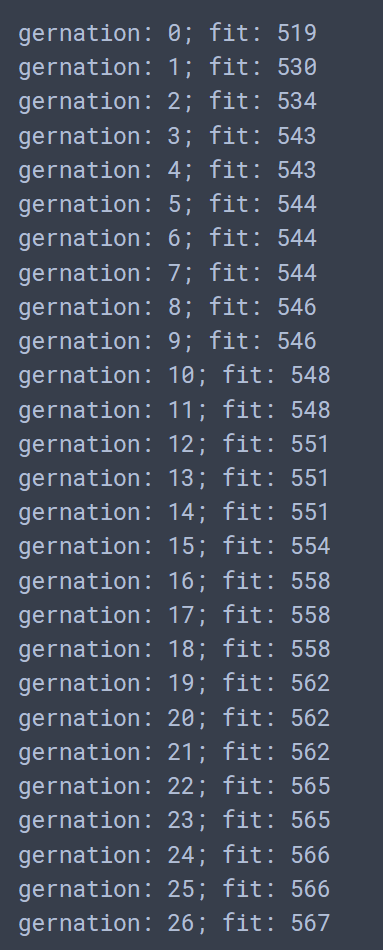

no_participants = 300 
no_courses = 15
low_p_weight = 1
high_p_weight = 5
participant_limit_per_course = 35
mutation_probability = 0.5
no_mutation_replacements = no_participants * 0.1
population_size = 6
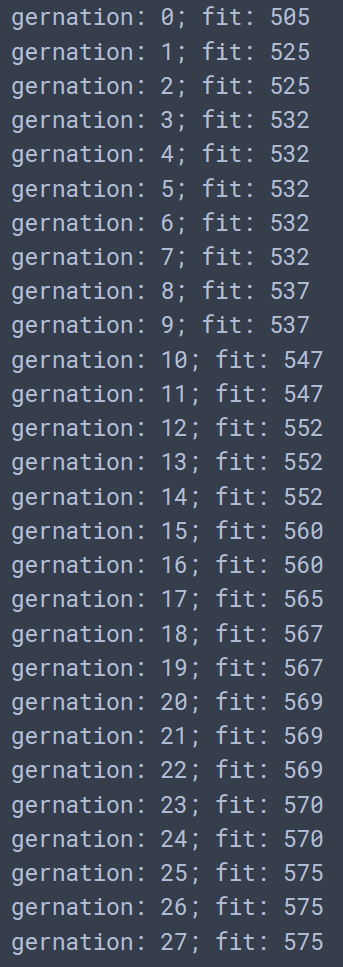

no_participants = 300 no_courses = 15 low_p_weight = 1 high_p_weight = 5 participant_limit_per_course = 35 mutation_probability = 0.5 no_mutation_replacements = no_participants * 0.2 population_size = 6
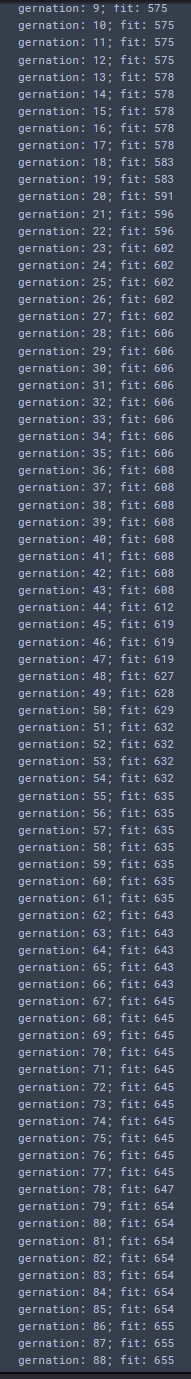

# Bayesian optimization of hyperparameters

## Adapt run_evolution func for byes_opt

In [36]:
def run_evolotuion_bayes_opt(
  no_mutation_replacements,
  mutation_probability,
  high_p_weight,
  population_size,
  population_func=generate_population,
  fitness_func=fitness,
  selection_func=selection_pair,
  crossover_func=single_point_crossover,
  mutation_func=mutation,
  gernation_limit=100,
  fitness_limit=(5 + 4)/2
):
  
  # generate first population
  population = population_func(int(population_size), high_p=int(high_p_weight))
  
  print('\n')
  for generation_no in range(100):
    # sort population for fitness (best fitting first)
    population = sorted(
      population,
      key=lambda genome: fitness_func(genome),
      reverse=True
    )
    print(f"gernation: {generation_no}; fit: {fitness_func(population[0])/no_participants/2} points per participant")
    
    if fitness_func(population[0]) >= fitness_limit:
      break
    
    # generate next generation's population by taking two solutions (more fitting = more likly)...
    # ...and use offsprings by mutationg and crossing over
    next_generation = population[0:2]
    
    for j in range(int(len(population) / 2) - 1):
      parents = selection_func(population, fitness_func)
      offspring_a, offspring_b = crossover_func(parents[0], parents[1])
      offspring_a = mutation_func(offspring_a, propability=mutation_probability, no_replacements=int(no_mutation_replacements))
      offspring_b = mutation_func(offspring_b, propability=mutation_probability, no_replacements=int(no_mutation_replacements))
      next_generation += [offspring_a, offspring_b]
      
    population = next_generation
    
  population = sorted(
    population,
    key=lambda genome: fitness_func(genome),
    reverse=True
  )
  print('\n')
  return fitness_func(population[0])/no_participants/2

## Run bayes_opt

In [37]:
from bayes_opt import BayesianOptimization
import time
import datetime

n_iter = 100
# How many steps of bayesian optimization you want to perform.
# The more steps the more likely to find a good maximum you are.

init_points = 10
# How many steps of random exploration you want to perform.
# Random exploration can help by diversifying the exploration space.


# Supress NaN warnings
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

# Bounded region of parameter space
pbounds = {
  'high_p_weight' : (1, 15),
  'mutation_probability' : (0.3, 0.8),
  'no_mutation_replacements' : (no_participants * 0.1, no_participants * 0.8),
  'population_size' : (6,20)
}

optimizer = BayesianOptimization(
    f=run_evolotuion_bayes_opt,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum 
    # is observed, verbose = 0 is silent
    random_state=1
)

start_time = time.time()
optimizer.maximize(init_points=init_points, n_iter=n_iter,)
time_took = time.time() - start_time

print(f"Total runtime: {datetime.timedelta(seconds=time_took)}")
print(optimizer.max)

|   iter    |  target   | high_p... | mutati... | no_mut... | popula... |
-------------------------------------------------------------------------


gernation: 0; fit: 0.0 points per participant
gernation: 1; fit: 0.0 points per participant
gernation: 2; fit: 0.0 points per participant
gernation: 3; fit: 0.0 points per participant
gernation: 4; fit: 0.0 points per participant
gernation: 5; fit: 0.0 points per participant
gernation: 6; fit: 0.0 points per participant
gernation: 7; fit: 0.0 points per participant
gernation: 8; fit: 0.0 points per participant
gernation: 9; fit: 0.0 points per participant
gernation: 10; fit: 0.0 points per participant
gernation: 11; fit: 0.0 points per participant
gernation: 12; fit: 0.0 points per participant
gernation: 13; fit: 0.0 points per participant
gernation: 14; fit: 0.0 points per participant
gernation: 15; fit: 0.0 points per participant
gernation: 16; fit: 0.0 points per participant
gernation: 17; fit: 0.0 points per participant
gernation: 18;

gernation: 66; fit: 1.832 points per participant
gernation: 67; fit: 1.834 points per participant
gernation: 68; fit: 1.836 points per participant
gernation: 69; fit: 1.836 points per participant
gernation: 70; fit: 1.836 points per participant
gernation: 71; fit: 1.836 points per participant
gernation: 72; fit: 1.836 points per participant
gernation: 73; fit: 1.842 points per participant
gernation: 74; fit: 1.842 points per participant
gernation: 75; fit: 1.842 points per participant
gernation: 76; fit: 1.846 points per participant
gernation: 77; fit: 1.858 points per participant
gernation: 78; fit: 1.858 points per participant
gernation: 79; fit: 1.858 points per participant
gernation: 80; fit: 1.858 points per participant
gernation: 81; fit: 1.88 points per participant
gernation: 82; fit: 1.88 points per participant
gernation: 83; fit: 1.88 points per participant
gernation: 84; fit: 1.888 points per participant
gernation: 85; fit: 1.888 points per participant
gernation: 86; fit: 1.8

gernation: 29; fit: 1.704 points per participant
gernation: 30; fit: 1.704 points per participant
gernation: 31; fit: 1.718 points per participant
gernation: 32; fit: 1.718 points per participant
gernation: 33; fit: 1.718 points per participant
gernation: 34; fit: 1.718 points per participant
gernation: 35; fit: 1.732 points per participant
gernation: 36; fit: 1.756 points per participant
gernation: 37; fit: 1.756 points per participant
gernation: 38; fit: 1.756 points per participant
gernation: 39; fit: 1.756 points per participant
gernation: 40; fit: 1.756 points per participant
gernation: 41; fit: 1.756 points per participant
gernation: 42; fit: 1.756 points per participant
gernation: 43; fit: 1.772 points per participant
gernation: 44; fit: 1.772 points per participant
gernation: 45; fit: 1.776 points per participant
gernation: 46; fit: 1.798 points per participant
gernation: 47; fit: 1.82 points per participant
gernation: 48; fit: 1.83 points per participant
gernation: 49; fit: 1.

gernation: 98; fit: 0.0 points per participant
gernation: 99; fit: 0.0 points per participant


| 5         | 0.0       | 6.842     | 0.5793    | 49.57     | 8.773     |


gernation: 0; fit: 0.0 points per participant
gernation: 1; fit: 0.0 points per participant
gernation: 2; fit: 0.0 points per participant
gernation: 3; fit: 1.52 points per participant
gernation: 4; fit: 1.55 points per participant
gernation: 5; fit: 1.564 points per participant
gernation: 6; fit: 1.568 points per participant
gernation: 7; fit: 1.584 points per participant
gernation: 8; fit: 1.606 points per participant
gernation: 9; fit: 1.606 points per participant
gernation: 10; fit: 1.618 points per participant
gernation: 11; fit: 1.618 points per participant
gernation: 12; fit: 1.618 points per participant
gernation: 13; fit: 1.618 points per participant
gernation: 14; fit: 1.674 points per participant
gernation: 15; fit: 1.674 points per participant
gernation: 16; fit: 1.674 points per participant
gernation: 17

gernation: 64; fit: 0.0 points per participant
gernation: 65; fit: 0.0 points per participant
gernation: 66; fit: 0.0 points per participant
gernation: 67; fit: 0.0 points per participant
gernation: 68; fit: 0.0 points per participant
gernation: 69; fit: 0.0 points per participant
gernation: 70; fit: 0.0 points per participant
gernation: 71; fit: 0.0 points per participant
gernation: 72; fit: 0.0 points per participant
gernation: 73; fit: 0.0 points per participant
gernation: 74; fit: 0.0 points per participant
gernation: 75; fit: 0.0 points per participant
gernation: 76; fit: 0.0 points per participant
gernation: 77; fit: 0.0 points per participant
gernation: 78; fit: 0.0 points per participant
gernation: 79; fit: 0.0 points per participant
gernation: 80; fit: 0.0 points per participant
gernation: 81; fit: 0.0 points per participant
gernation: 82; fit: 0.0 points per participant
gernation: 83; fit: 0.0 points per participant
gernation: 84; fit: 0.0 points per participant
gernation: 85

gernation: 30; fit: 1.69 points per participant
gernation: 31; fit: 1.69 points per participant
gernation: 32; fit: 1.69 points per participant
gernation: 33; fit: 1.692 points per participant
gernation: 34; fit: 1.694 points per participant
gernation: 35; fit: 1.728 points per participant
gernation: 36; fit: 1.728 points per participant
gernation: 37; fit: 1.728 points per participant
gernation: 38; fit: 1.728 points per participant
gernation: 39; fit: 1.728 points per participant
gernation: 40; fit: 1.728 points per participant
gernation: 41; fit: 1.78 points per participant
gernation: 42; fit: 1.78 points per participant
gernation: 43; fit: 1.78 points per participant
gernation: 44; fit: 1.78 points per participant
gernation: 45; fit: 1.78 points per participant
gernation: 46; fit: 1.78 points per participant
gernation: 47; fit: 1.78 points per participant
gernation: 48; fit: 1.78 points per participant
gernation: 49; fit: 1.79 points per participant
gernation: 50; fit: 1.79 points 

gernation: 97; fit: 1.952 points per participant
gernation: 98; fit: 1.952 points per participant
gernation: 99; fit: 1.952 points per participant


| 10        | 1.952     | 10.61     | 0.7173    | 28.2      | 16.5      |


gernation: 0; fit: 0.0 points per participant
gernation: 1; fit: 0.0 points per participant
gernation: 2; fit: 0.0 points per participant
gernation: 3; fit: 0.0 points per participant
gernation: 4; fit: 0.0 points per participant
gernation: 5; fit: 0.0 points per participant
gernation: 6; fit: 0.0 points per participant
gernation: 7; fit: 0.0 points per participant
gernation: 8; fit: 0.0 points per participant
gernation: 9; fit: 0.0 points per participant
gernation: 10; fit: 0.0 points per participant
gernation: 11; fit: 0.0 points per participant
gernation: 12; fit: 0.0 points per participant
gernation: 13; fit: 0.0 points per participant
gernation: 14; fit: 0.0 points per participant
gernation: 15; fit: 0.0 points per participant
gernation: 16; fit: 0.0 points pe

gernation: 65; fit: 1.706 points per participant
gernation: 66; fit: 1.714 points per participant
gernation: 67; fit: 1.714 points per participant
gernation: 68; fit: 1.714 points per participant
gernation: 69; fit: 1.714 points per participant
gernation: 70; fit: 1.742 points per participant
gernation: 71; fit: 1.744 points per participant
gernation: 72; fit: 1.746 points per participant
gernation: 73; fit: 1.786 points per participant
gernation: 74; fit: 1.8 points per participant
gernation: 75; fit: 1.8 points per participant
gernation: 76; fit: 1.804 points per participant
gernation: 77; fit: 1.804 points per participant
gernation: 78; fit: 1.818 points per participant
gernation: 79; fit: 1.818 points per participant
gernation: 80; fit: 1.818 points per participant
gernation: 81; fit: 1.818 points per participant
gernation: 82; fit: 1.818 points per participant
gernation: 83; fit: 1.836 points per participant
gernation: 84; fit: 1.836 points per participant
gernation: 85; fit: 1.83

gernation: 29; fit: 1.77 points per participant
gernation: 30; fit: 1.77 points per participant
gernation: 31; fit: 1.77 points per participant
gernation: 32; fit: 1.77 points per participant
gernation: 33; fit: 1.782 points per participant
gernation: 34; fit: 1.796 points per participant
gernation: 35; fit: 1.796 points per participant
gernation: 36; fit: 1.796 points per participant
gernation: 37; fit: 1.796 points per participant
gernation: 38; fit: 1.796 points per participant
gernation: 39; fit: 1.796 points per participant
gernation: 40; fit: 1.796 points per participant
gernation: 41; fit: 1.804 points per participant
gernation: 42; fit: 1.804 points per participant
gernation: 43; fit: 1.824 points per participant
gernation: 44; fit: 1.846 points per participant
gernation: 45; fit: 1.88 points per participant
gernation: 46; fit: 1.88 points per participant
gernation: 47; fit: 1.88 points per participant
gernation: 48; fit: 1.894 points per participant
gernation: 49; fit: 1.904 p

gernation: 95; fit: 1.978 points per participant
gernation: 96; fit: 1.978 points per participant
gernation: 97; fit: 1.998 points per participant
gernation: 98; fit: 1.998 points per participant
gernation: 99; fit: 2.006 points per participant


| 15        | 2.006     | 1.0       | 0.3       | 64.89     | 12.89     |


gernation: 0; fit: 1.626 points per participant
gernation: 1; fit: 1.626 points per participant
gernation: 2; fit: 1.626 points per participant
gernation: 3; fit: 1.642 points per participant
gernation: 4; fit: 1.642 points per participant
gernation: 5; fit: 1.642 points per participant
gernation: 6; fit: 1.652 points per participant
gernation: 7; fit: 1.652 points per participant
gernation: 8; fit: 1.656 points per participant
gernation: 9; fit: 1.672 points per participant
gernation: 10; fit: 1.674 points per participant
gernation: 11; fit: 1.674 points per participant
gernation: 12; fit: 1.69 points per participant
gernation: 13; fit: 1.71 points per participant
ger

gernation: 59; fit: 1.806 points per participant
gernation: 60; fit: 1.806 points per participant
gernation: 61; fit: 1.806 points per participant
gernation: 62; fit: 1.806 points per participant
gernation: 63; fit: 1.806 points per participant
gernation: 64; fit: 1.806 points per participant
gernation: 65; fit: 1.806 points per participant
gernation: 66; fit: 1.806 points per participant
gernation: 67; fit: 1.856 points per participant
gernation: 68; fit: 1.86 points per participant
gernation: 69; fit: 1.86 points per participant
gernation: 70; fit: 1.86 points per participant
gernation: 71; fit: 1.882 points per participant
gernation: 72; fit: 1.882 points per participant
gernation: 73; fit: 1.882 points per participant
gernation: 74; fit: 1.882 points per participant
gernation: 75; fit: 1.882 points per participant
gernation: 76; fit: 1.882 points per participant
gernation: 77; fit: 1.882 points per participant
gernation: 78; fit: 1.882 points per participant
gernation: 79; fit: 1.8

gernation: 23; fit: 1.562 points per participant
gernation: 24; fit: 1.584 points per participant
gernation: 25; fit: 1.584 points per participant
gernation: 26; fit: 1.584 points per participant
gernation: 27; fit: 1.584 points per participant
gernation: 28; fit: 1.598 points per participant
gernation: 29; fit: 1.624 points per participant
gernation: 30; fit: 1.624 points per participant
gernation: 31; fit: 1.624 points per participant
gernation: 32; fit: 1.624 points per participant
gernation: 33; fit: 1.624 points per participant
gernation: 34; fit: 1.658 points per participant
gernation: 35; fit: 1.658 points per participant
gernation: 36; fit: 1.658 points per participant
gernation: 37; fit: 1.658 points per participant
gernation: 38; fit: 1.658 points per participant
gernation: 39; fit: 1.728 points per participant
gernation: 40; fit: 1.728 points per participant
gernation: 41; fit: 1.728 points per participant
gernation: 42; fit: 1.728 points per participant
gernation: 43; fit: 

gernation: 89; fit: 1.858 points per participant
gernation: 90; fit: 1.858 points per participant
gernation: 91; fit: 1.864 points per participant
gernation: 92; fit: 1.864 points per participant
gernation: 93; fit: 1.864 points per participant
gernation: 94; fit: 1.864 points per participant
gernation: 95; fit: 1.864 points per participant
gernation: 96; fit: 1.864 points per participant
gernation: 97; fit: 1.864 points per participant
gernation: 98; fit: 1.864 points per participant
gernation: 99; fit: 1.874 points per participant


| 20        | 1.908     | 4.081     | 0.5298    | 87.13     | 15.14     |


gernation: 0; fit: 0.0 points per participant
gernation: 1; fit: 0.0 points per participant
gernation: 2; fit: 0.0 points per participant
gernation: 3; fit: 0.0 points per participant
gernation: 4; fit: 1.6 points per participant
gernation: 5; fit: 1.616 points per participant
gernation: 6; fit: 1.616 points per participant
gernation: 7; fit: 1.648 points per participant
gernation

gernation: 55; fit: 0.0 points per participant
gernation: 56; fit: 0.0 points per participant
gernation: 57; fit: 0.0 points per participant
gernation: 58; fit: 0.0 points per participant
gernation: 59; fit: 0.0 points per participant
gernation: 60; fit: 0.0 points per participant
gernation: 61; fit: 0.0 points per participant
gernation: 62; fit: 0.0 points per participant
gernation: 63; fit: 0.0 points per participant
gernation: 64; fit: 0.0 points per participant
gernation: 65; fit: 0.0 points per participant
gernation: 66; fit: 0.0 points per participant
gernation: 67; fit: 0.0 points per participant
gernation: 68; fit: 0.0 points per participant
gernation: 69; fit: 0.0 points per participant
gernation: 70; fit: 1.496 points per participant
gernation: 71; fit: 1.496 points per participant
gernation: 72; fit: 1.5 points per participant
gernation: 73; fit: 1.5 points per participant
gernation: 74; fit: 1.522 points per participant
gernation: 75; fit: 1.522 points per participant
gerna

gernation: 20; fit: 1.708 points per participant
gernation: 21; fit: 1.708 points per participant
gernation: 22; fit: 1.708 points per participant
gernation: 23; fit: 1.708 points per participant
gernation: 24; fit: 1.708 points per participant
gernation: 25; fit: 1.708 points per participant
gernation: 26; fit: 1.708 points per participant
gernation: 27; fit: 1.708 points per participant
gernation: 28; fit: 1.708 points per participant
gernation: 29; fit: 1.708 points per participant
gernation: 30; fit: 1.708 points per participant
gernation: 31; fit: 1.708 points per participant
gernation: 32; fit: 1.708 points per participant
gernation: 33; fit: 1.708 points per participant
gernation: 34; fit: 1.708 points per participant
gernation: 35; fit: 1.708 points per participant
gernation: 36; fit: 1.708 points per participant
gernation: 37; fit: 1.708 points per participant
gernation: 38; fit: 1.71 points per participant
gernation: 39; fit: 1.71 points per participant
gernation: 40; fit: 1.

gernation: 86; fit: 1.86 points per participant
gernation: 87; fit: 1.86 points per participant
gernation: 88; fit: 1.86 points per participant
gernation: 89; fit: 1.86 points per participant
gernation: 90; fit: 1.86 points per participant
gernation: 91; fit: 1.86 points per participant
gernation: 92; fit: 1.86 points per participant
gernation: 93; fit: 1.86 points per participant
gernation: 94; fit: 1.86 points per participant
gernation: 95; fit: 1.86 points per participant
gernation: 96; fit: 1.86 points per participant
gernation: 97; fit: 1.86 points per participant
gernation: 98; fit: 1.86 points per participant
gernation: 99; fit: 1.86 points per participant


| 25        | 1.86      | 10.86     | 0.7288    | 108.1     | 19.21     |


gernation: 0; fit: 0.0 points per participant
gernation: 1; fit: 0.0 points per participant
gernation: 2; fit: 0.0 points per participant
gernation: 3; fit: 1.552 points per participant
gernation: 4; fit: 1.562 points per participant
gernation: 5; fi

gernation: 50; fit: 1.806 points per participant
gernation: 51; fit: 1.806 points per participant
gernation: 52; fit: 1.838 points per participant
gernation: 53; fit: 1.838 points per participant
gernation: 54; fit: 1.838 points per participant
gernation: 55; fit: 1.838 points per participant
gernation: 56; fit: 1.838 points per participant
gernation: 57; fit: 1.838 points per participant
gernation: 58; fit: 1.838 points per participant
gernation: 59; fit: 1.838 points per participant
gernation: 60; fit: 1.838 points per participant
gernation: 61; fit: 1.838 points per participant
gernation: 62; fit: 1.838 points per participant
gernation: 63; fit: 1.838 points per participant
gernation: 64; fit: 1.838 points per participant
gernation: 65; fit: 1.838 points per participant
gernation: 66; fit: 1.838 points per participant
gernation: 67; fit: 1.838 points per participant
gernation: 68; fit: 1.838 points per participant
gernation: 69; fit: 1.838 points per participant
gernation: 70; fit: 

gernation: 14; fit: 1.734 points per participant
gernation: 15; fit: 1.734 points per participant
gernation: 16; fit: 1.782 points per participant
gernation: 17; fit: 1.782 points per participant
gernation: 18; fit: 1.782 points per participant
gernation: 19; fit: 1.782 points per participant
gernation: 20; fit: 1.782 points per participant
gernation: 21; fit: 1.786 points per participant
gernation: 22; fit: 1.786 points per participant
gernation: 23; fit: 1.786 points per participant
gernation: 24; fit: 1.836 points per participant
gernation: 25; fit: 1.844 points per participant
gernation: 26; fit: 1.862 points per participant
gernation: 27; fit: 1.862 points per participant
gernation: 28; fit: 1.862 points per participant
gernation: 29; fit: 1.862 points per participant
gernation: 30; fit: 1.862 points per participant
gernation: 31; fit: 1.862 points per participant
gernation: 32; fit: 1.874 points per participant
gernation: 33; fit: 1.878 points per participant
gernation: 34; fit: 

gernation: 80; fit: 1.822 points per participant
gernation: 81; fit: 1.822 points per participant
gernation: 82; fit: 1.822 points per participant
gernation: 83; fit: 1.84 points per participant
gernation: 84; fit: 1.84 points per participant
gernation: 85; fit: 1.84 points per participant
gernation: 86; fit: 1.84 points per participant
gernation: 87; fit: 1.84 points per participant
gernation: 88; fit: 1.84 points per participant
gernation: 89; fit: 1.84 points per participant
gernation: 90; fit: 1.84 points per participant
gernation: 91; fit: 1.84 points per participant
gernation: 92; fit: 1.84 points per participant
gernation: 93; fit: 1.84 points per participant
gernation: 94; fit: 1.84 points per participant
gernation: 95; fit: 1.84 points per participant
gernation: 96; fit: 1.84 points per participant
gernation: 97; fit: 1.84 points per participant
gernation: 98; fit: 1.856 points per participant
gernation: 99; fit: 1.856 points per participant


| 30        | 1.866     | 10.73  

gernation: 46; fit: 1.746 points per participant
gernation: 47; fit: 1.746 points per participant
gernation: 48; fit: 1.76 points per participant
gernation: 49; fit: 1.76 points per participant
gernation: 50; fit: 1.76 points per participant
gernation: 51; fit: 1.76 points per participant
gernation: 52; fit: 1.76 points per participant
gernation: 53; fit: 1.76 points per participant
gernation: 54; fit: 1.76 points per participant
gernation: 55; fit: 1.76 points per participant
gernation: 56; fit: 1.76 points per participant
gernation: 57; fit: 1.76 points per participant
gernation: 58; fit: 1.76 points per participant
gernation: 59; fit: 1.76 points per participant
gernation: 60; fit: 1.76 points per participant
gernation: 61; fit: 1.76 points per participant
gernation: 62; fit: 1.76 points per participant
gernation: 63; fit: 1.76 points per participant
gernation: 64; fit: 1.76 points per participant
gernation: 65; fit: 1.76 points per participant
gernation: 66; fit: 1.76 points per pa

gernation: 12; fit: 0.0 points per participant
gernation: 13; fit: 0.0 points per participant
gernation: 14; fit: 0.0 points per participant
gernation: 15; fit: 0.0 points per participant
gernation: 16; fit: 0.0 points per participant
gernation: 17; fit: 0.0 points per participant
gernation: 18; fit: 0.0 points per participant
gernation: 19; fit: 0.0 points per participant
gernation: 20; fit: 0.0 points per participant
gernation: 21; fit: 0.0 points per participant
gernation: 22; fit: 0.0 points per participant
gernation: 23; fit: 0.0 points per participant
gernation: 24; fit: 0.0 points per participant
gernation: 25; fit: 0.0 points per participant
gernation: 26; fit: 0.0 points per participant
gernation: 27; fit: 0.0 points per participant
gernation: 28; fit: 0.0 points per participant
gernation: 29; fit: 1.624 points per participant
gernation: 30; fit: 1.638 points per participant
gernation: 31; fit: 1.638 points per participant
gernation: 32; fit: 1.638 points per participant
gerna

gernation: 79; fit: 1.786 points per participant
gernation: 80; fit: 1.786 points per participant
gernation: 81; fit: 1.786 points per participant
gernation: 82; fit: 1.786 points per participant
gernation: 83; fit: 1.786 points per participant
gernation: 84; fit: 1.786 points per participant
gernation: 85; fit: 1.786 points per participant
gernation: 86; fit: 1.786 points per participant
gernation: 87; fit: 1.786 points per participant
gernation: 88; fit: 1.816 points per participant
gernation: 89; fit: 1.816 points per participant
gernation: 90; fit: 1.816 points per participant
gernation: 91; fit: 1.816 points per participant
gernation: 92; fit: 1.816 points per participant
gernation: 93; fit: 1.816 points per participant
gernation: 94; fit: 1.816 points per participant
gernation: 95; fit: 1.816 points per participant
gernation: 96; fit: 1.816 points per participant
gernation: 97; fit: 1.816 points per participant
gernation: 98; fit: 1.816 points per participant
gernation: 99; fit: 

gernation: 43; fit: 1.794 points per participant
gernation: 44; fit: 1.794 points per participant
gernation: 45; fit: 1.794 points per participant
gernation: 46; fit: 1.794 points per participant
gernation: 47; fit: 1.794 points per participant
gernation: 48; fit: 1.794 points per participant
gernation: 49; fit: 1.794 points per participant
gernation: 50; fit: 1.794 points per participant
gernation: 51; fit: 1.794 points per participant
gernation: 52; fit: 1.8 points per participant
gernation: 53; fit: 1.8 points per participant
gernation: 54; fit: 1.8 points per participant
gernation: 55; fit: 1.802 points per participant
gernation: 56; fit: 1.802 points per participant
gernation: 57; fit: 1.802 points per participant
gernation: 58; fit: 1.802 points per participant
gernation: 59; fit: 1.802 points per participant
gernation: 60; fit: 1.802 points per participant
gernation: 61; fit: 1.802 points per participant
gernation: 62; fit: 1.802 points per participant
gernation: 63; fit: 1.858 

gernation: 7; fit: 1.63 points per participant
gernation: 8; fit: 1.638 points per participant
gernation: 9; fit: 1.638 points per participant
gernation: 10; fit: 1.652 points per participant
gernation: 11; fit: 1.666 points per participant
gernation: 12; fit: 1.698 points per participant
gernation: 13; fit: 1.698 points per participant
gernation: 14; fit: 1.698 points per participant
gernation: 15; fit: 1.698 points per participant
gernation: 16; fit: 1.698 points per participant
gernation: 17; fit: 1.698 points per participant
gernation: 18; fit: 1.698 points per participant
gernation: 19; fit: 1.714 points per participant
gernation: 20; fit: 1.714 points per participant
gernation: 21; fit: 1.714 points per participant
gernation: 22; fit: 1.714 points per participant
gernation: 23; fit: 1.714 points per participant
gernation: 24; fit: 1.714 points per participant
gernation: 25; fit: 1.714 points per participant
gernation: 26; fit: 1.72 points per participant
gernation: 27; fit: 1.766

gernation: 73; fit: 1.836 points per participant
gernation: 74; fit: 1.836 points per participant
gernation: 75; fit: 1.836 points per participant
gernation: 76; fit: 1.836 points per participant
gernation: 77; fit: 1.836 points per participant
gernation: 78; fit: 1.836 points per participant
gernation: 79; fit: 1.836 points per participant
gernation: 80; fit: 1.836 points per participant
gernation: 81; fit: 1.836 points per participant
gernation: 82; fit: 1.888 points per participant
gernation: 83; fit: 1.888 points per participant
gernation: 84; fit: 1.888 points per participant
gernation: 85; fit: 1.888 points per participant
gernation: 86; fit: 1.888 points per participant
gernation: 87; fit: 1.888 points per participant
gernation: 88; fit: 1.888 points per participant
gernation: 89; fit: 1.892 points per participant
gernation: 90; fit: 1.892 points per participant
gernation: 91; fit: 1.892 points per participant
gernation: 92; fit: 1.892 points per participant
gernation: 93; fit: 

gernation: 37; fit: 1.838 points per participant
gernation: 38; fit: 1.838 points per participant
gernation: 39; fit: 1.838 points per participant
gernation: 40; fit: 1.838 points per participant
gernation: 41; fit: 1.838 points per participant
gernation: 42; fit: 1.838 points per participant
gernation: 43; fit: 1.838 points per participant
gernation: 44; fit: 1.838 points per participant
gernation: 45; fit: 1.838 points per participant
gernation: 46; fit: 1.838 points per participant
gernation: 47; fit: 1.838 points per participant
gernation: 48; fit: 1.838 points per participant
gernation: 49; fit: 1.838 points per participant
gernation: 50; fit: 1.838 points per participant
gernation: 51; fit: 1.838 points per participant
gernation: 52; fit: 1.838 points per participant
gernation: 53; fit: 1.838 points per participant
gernation: 54; fit: 1.838 points per participant
gernation: 55; fit: 1.838 points per participant
gernation: 56; fit: 1.838 points per participant
gernation: 57; fit: 

gernation: 0; fit: 0.0 points per participant
gernation: 1; fit: 0.0 points per participant
gernation: 2; fit: 0.0 points per participant
gernation: 3; fit: 0.0 points per participant
gernation: 4; fit: 0.0 points per participant
gernation: 5; fit: 1.562 points per participant
gernation: 6; fit: 1.606 points per participant
gernation: 7; fit: 1.606 points per participant
gernation: 8; fit: 1.606 points per participant
gernation: 9; fit: 1.606 points per participant
gernation: 10; fit: 1.62 points per participant
gernation: 11; fit: 1.632 points per participant
gernation: 12; fit: 1.674 points per participant
gernation: 13; fit: 1.674 points per participant
gernation: 14; fit: 1.674 points per participant
gernation: 15; fit: 1.674 points per participant
gernation: 16; fit: 1.674 points per participant
gernation: 17; fit: 1.71 points per participant
gernation: 18; fit: 1.71 points per participant
gernation: 19; fit: 1.71 points per participant
gernation: 20; fit: 1.71 points per particip

gernation: 67; fit: 1.74 points per participant
gernation: 68; fit: 1.74 points per participant
gernation: 69; fit: 1.74 points per participant
gernation: 70; fit: 1.74 points per participant
gernation: 71; fit: 1.74 points per participant
gernation: 72; fit: 1.74 points per participant
gernation: 73; fit: 1.74 points per participant
gernation: 74; fit: 1.74 points per participant
gernation: 75; fit: 1.806 points per participant
gernation: 76; fit: 1.806 points per participant
gernation: 77; fit: 1.806 points per participant
gernation: 78; fit: 1.806 points per participant
gernation: 79; fit: 1.806 points per participant
gernation: 80; fit: 1.806 points per participant
gernation: 81; fit: 1.806 points per participant
gernation: 82; fit: 1.806 points per participant
gernation: 83; fit: 1.806 points per participant
gernation: 84; fit: 1.806 points per participant
gernation: 85; fit: 1.806 points per participant
gernation: 86; fit: 1.806 points per participant
gernation: 87; fit: 1.806 po

gernation: 31; fit: 1.74 points per participant
gernation: 32; fit: 1.74 points per participant
gernation: 33; fit: 1.752 points per participant
gernation: 34; fit: 1.762 points per participant
gernation: 35; fit: 1.762 points per participant
gernation: 36; fit: 1.762 points per participant
gernation: 37; fit: 1.762 points per participant
gernation: 38; fit: 1.762 points per participant
gernation: 39; fit: 1.762 points per participant
gernation: 40; fit: 1.762 points per participant
gernation: 41; fit: 1.762 points per participant
gernation: 42; fit: 1.762 points per participant
gernation: 43; fit: 1.762 points per participant
gernation: 44; fit: 1.764 points per participant
gernation: 45; fit: 1.764 points per participant
gernation: 46; fit: 1.772 points per participant
gernation: 47; fit: 1.772 points per participant
gernation: 48; fit: 1.772 points per participant
gernation: 49; fit: 1.772 points per participant
gernation: 50; fit: 1.772 points per participant
gernation: 51; fit: 1.

gernation: 98; fit: 1.89 points per participant
gernation: 99; fit: 1.89 points per participant


| 48        | 1.89      | 2.003     | 0.3       | 172.5     | 20.0      |


gernation: 0; fit: 1.61 points per participant
gernation: 1; fit: 1.654 points per participant
gernation: 2; fit: 1.654 points per participant
gernation: 3; fit: 1.662 points per participant
gernation: 4; fit: 1.662 points per participant
gernation: 5; fit: 1.662 points per participant
gernation: 6; fit: 1.662 points per participant
gernation: 7; fit: 1.698 points per participant
gernation: 8; fit: 1.698 points per participant
gernation: 9; fit: 1.712 points per participant
gernation: 10; fit: 1.712 points per participant
gernation: 11; fit: 1.712 points per participant
gernation: 12; fit: 1.712 points per participant
gernation: 13; fit: 1.712 points per participant
gernation: 14; fit: 1.718 points per participant
gernation: 15; fit: 1.728 points per participant
gernation: 16; fit: 1.728 points per participant
gern

gernation: 62; fit: 1.756 points per participant
gernation: 63; fit: 1.756 points per participant
gernation: 64; fit: 1.756 points per participant
gernation: 65; fit: 1.756 points per participant
gernation: 66; fit: 1.756 points per participant
gernation: 67; fit: 1.758 points per participant
gernation: 68; fit: 1.758 points per participant
gernation: 69; fit: 1.758 points per participant
gernation: 70; fit: 1.758 points per participant
gernation: 71; fit: 1.758 points per participant
gernation: 72; fit: 1.758 points per participant
gernation: 73; fit: 1.758 points per participant
gernation: 74; fit: 1.758 points per participant
gernation: 75; fit: 1.758 points per participant
gernation: 76; fit: 1.758 points per participant
gernation: 77; fit: 1.758 points per participant
gernation: 78; fit: 1.758 points per participant
gernation: 79; fit: 1.758 points per participant
gernation: 80; fit: 1.758 points per participant
gernation: 81; fit: 1.774 points per participant
gernation: 82; fit: 

gernation: 26; fit: 1.75 points per participant
gernation: 27; fit: 1.774 points per participant
gernation: 28; fit: 1.774 points per participant
gernation: 29; fit: 1.774 points per participant
gernation: 30; fit: 1.792 points per participant
gernation: 31; fit: 1.792 points per participant
gernation: 32; fit: 1.792 points per participant
gernation: 33; fit: 1.792 points per participant
gernation: 34; fit: 1.808 points per participant
gernation: 35; fit: 1.808 points per participant
gernation: 36; fit: 1.808 points per participant
gernation: 37; fit: 1.808 points per participant
gernation: 38; fit: 1.808 points per participant
gernation: 39; fit: 1.808 points per participant
gernation: 40; fit: 1.808 points per participant
gernation: 41; fit: 1.808 points per participant
gernation: 42; fit: 1.808 points per participant
gernation: 43; fit: 1.808 points per participant
gernation: 44; fit: 1.82 points per participant
gernation: 45; fit: 1.82 points per participant
gernation: 46; fit: 1.8

gernation: 92; fit: 1.952 points per participant
gernation: 93; fit: 1.962 points per participant
gernation: 94; fit: 1.962 points per participant
gernation: 95; fit: 1.962 points per participant
gernation: 96; fit: 1.962 points per participant
gernation: 97; fit: 1.962 points per participant
gernation: 98; fit: 1.962 points per participant
gernation: 99; fit: 1.962 points per participant


| 53        | 1.962     | 9.328     | 0.3       | 117.4     | 20.0      |


gernation: 0; fit: 0.0 points per participant
gernation: 1; fit: 0.0 points per participant
gernation: 2; fit: 0.0 points per participant
gernation: 3; fit: 0.0 points per participant
gernation: 4; fit: 0.0 points per participant
gernation: 5; fit: 0.0 points per participant
gernation: 6; fit: 0.0 points per participant
gernation: 7; fit: 0.0 points per participant
gernation: 8; fit: 0.0 points per participant
gernation: 9; fit: 0.0 points per participant
gernation: 10; fit: 0.0 points per participant
gernation: 11; fit: 0.0

gernation: 59; fit: 1.822 points per participant
gernation: 60; fit: 1.822 points per participant
gernation: 61; fit: 1.822 points per participant
gernation: 62; fit: 1.822 points per participant
gernation: 63; fit: 1.822 points per participant
gernation: 64; fit: 1.822 points per participant
gernation: 65; fit: 1.822 points per participant
gernation: 66; fit: 1.822 points per participant
gernation: 67; fit: 1.822 points per participant
gernation: 68; fit: 1.822 points per participant
gernation: 69; fit: 1.822 points per participant
gernation: 70; fit: 1.822 points per participant
gernation: 71; fit: 1.822 points per participant
gernation: 72; fit: 1.822 points per participant
gernation: 73; fit: 1.822 points per participant
gernation: 74; fit: 1.822 points per participant
gernation: 75; fit: 1.822 points per participant
gernation: 76; fit: 1.838 points per participant
gernation: 77; fit: 1.838 points per participant
gernation: 78; fit: 1.838 points per participant
gernation: 79; fit: 

gernation: 23; fit: 1.66 points per participant
gernation: 24; fit: 1.66 points per participant
gernation: 25; fit: 1.66 points per participant
gernation: 26; fit: 1.674 points per participant
gernation: 27; fit: 1.674 points per participant
gernation: 28; fit: 1.68 points per participant
gernation: 29; fit: 1.68 points per participant
gernation: 30; fit: 1.68 points per participant
gernation: 31; fit: 1.68 points per participant
gernation: 32; fit: 1.68 points per participant
gernation: 33; fit: 1.68 points per participant
gernation: 34; fit: 1.68 points per participant
gernation: 35; fit: 1.68 points per participant
gernation: 36; fit: 1.68 points per participant
gernation: 37; fit: 1.68 points per participant
gernation: 38; fit: 1.68 points per participant
gernation: 39; fit: 1.68 points per participant
gernation: 40; fit: 1.68 points per participant
gernation: 41; fit: 1.692 points per participant
gernation: 42; fit: 1.692 points per participant
gernation: 43; fit: 1.692 points per

gernation: 89; fit: 1.856 points per participant
gernation: 90; fit: 1.856 points per participant
gernation: 91; fit: 1.86 points per participant
gernation: 92; fit: 1.86 points per participant
gernation: 93; fit: 1.86 points per participant
gernation: 94; fit: 1.86 points per participant
gernation: 95; fit: 1.86 points per participant
gernation: 96; fit: 1.86 points per participant
gernation: 97; fit: 1.86 points per participant
gernation: 98; fit: 1.86 points per participant
gernation: 99; fit: 1.86 points per participant


| 58        | 1.86      | 1.0       | 0.3       | 168.6     | 10.46     |


gernation: 0; fit: 1.49 points per participant
gernation: 1; fit: 1.524 points per participant
gernation: 2; fit: 1.524 points per participant
gernation: 3; fit: 1.532 points per participant
gernation: 4; fit: 1.55 points per participant
gernation: 5; fit: 1.56 points per participant
gernation: 6; fit: 1.568 points per participant
gernation: 7; fit: 1.568 points per participant
gernation: 

gernation: 54; fit: 1.722 points per participant
gernation: 55; fit: 1.722 points per participant
gernation: 56; fit: 1.722 points per participant
gernation: 57; fit: 1.722 points per participant
gernation: 58; fit: 1.722 points per participant
gernation: 59; fit: 1.722 points per participant
gernation: 60; fit: 1.722 points per participant
gernation: 61; fit: 1.73 points per participant
gernation: 62; fit: 1.766 points per participant
gernation: 63; fit: 1.766 points per participant
gernation: 64; fit: 1.766 points per participant
gernation: 65; fit: 1.766 points per participant
gernation: 66; fit: 1.766 points per participant
gernation: 67; fit: 1.766 points per participant
gernation: 68; fit: 1.766 points per participant
gernation: 69; fit: 1.766 points per participant
gernation: 70; fit: 1.766 points per participant
gernation: 71; fit: 1.766 points per participant
gernation: 72; fit: 1.766 points per participant
gernation: 73; fit: 1.766 points per participant
gernation: 74; fit: 1

gernation: 18; fit: 1.766 points per participant
gernation: 19; fit: 1.766 points per participant
gernation: 20; fit: 1.766 points per participant
gernation: 21; fit: 1.766 points per participant
gernation: 22; fit: 1.766 points per participant
gernation: 23; fit: 1.766 points per participant
gernation: 24; fit: 1.766 points per participant
gernation: 25; fit: 1.766 points per participant
gernation: 26; fit: 1.766 points per participant
gernation: 27; fit: 1.766 points per participant
gernation: 28; fit: 1.766 points per participant
gernation: 29; fit: 1.766 points per participant
gernation: 30; fit: 1.766 points per participant
gernation: 31; fit: 1.766 points per participant
gernation: 32; fit: 1.766 points per participant
gernation: 33; fit: 1.766 points per participant
gernation: 34; fit: 1.766 points per participant
gernation: 35; fit: 1.766 points per participant
gernation: 36; fit: 1.766 points per participant
gernation: 37; fit: 1.766 points per participant
gernation: 38; fit: 

gernation: 86; fit: 1.708 points per participant
gernation: 87; fit: 1.73 points per participant
gernation: 88; fit: 1.73 points per participant
gernation: 89; fit: 1.73 points per participant
gernation: 90; fit: 1.73 points per participant
gernation: 91; fit: 1.73 points per participant
gernation: 92; fit: 1.73 points per participant
gernation: 93; fit: 1.73 points per participant
gernation: 94; fit: 1.73 points per participant
gernation: 95; fit: 1.73 points per participant
gernation: 96; fit: 1.734 points per participant
gernation: 97; fit: 1.734 points per participant
gernation: 98; fit: 1.764 points per participant
gernation: 99; fit: 1.764 points per participant


| 63        | 1.77      | 14.88     | 0.6609    | 67.61     | 9.666     |


gernation: 0; fit: 0.0 points per participant
gernation: 1; fit: 0.0 points per participant
gernation: 2; fit: 1.584 points per participant
gernation: 3; fit: 1.616 points per participant
gernation: 4; fit: 1.624 points per participant
gernation

gernation: 51; fit: 1.782 points per participant
gernation: 52; fit: 1.782 points per participant
gernation: 53; fit: 1.782 points per participant
gernation: 54; fit: 1.782 points per participant
gernation: 55; fit: 1.782 points per participant
gernation: 56; fit: 1.782 points per participant
gernation: 57; fit: 1.782 points per participant
gernation: 58; fit: 1.782 points per participant
gernation: 59; fit: 1.782 points per participant
gernation: 60; fit: 1.792 points per participant
gernation: 61; fit: 1.792 points per participant
gernation: 62; fit: 1.792 points per participant
gernation: 63; fit: 1.792 points per participant
gernation: 64; fit: 1.798 points per participant
gernation: 65; fit: 1.802 points per participant
gernation: 66; fit: 1.802 points per participant
gernation: 67; fit: 1.804 points per participant
gernation: 68; fit: 1.804 points per participant
gernation: 69; fit: 1.804 points per participant
gernation: 70; fit: 1.804 points per participant
gernation: 71; fit: 

gernation: 15; fit: 0.0 points per participant
gernation: 16; fit: 0.0 points per participant
gernation: 17; fit: 0.0 points per participant
gernation: 18; fit: 0.0 points per participant
gernation: 19; fit: 0.0 points per participant
gernation: 20; fit: 0.0 points per participant
gernation: 21; fit: 0.0 points per participant
gernation: 22; fit: 0.0 points per participant
gernation: 23; fit: 0.0 points per participant
gernation: 24; fit: 0.0 points per participant
gernation: 25; fit: 0.0 points per participant
gernation: 26; fit: 0.0 points per participant
gernation: 27; fit: 0.0 points per participant
gernation: 28; fit: 1.5 points per participant
gernation: 29; fit: 1.512 points per participant
gernation: 30; fit: 1.512 points per participant
gernation: 31; fit: 1.558 points per participant
gernation: 32; fit: 1.562 points per participant
gernation: 33; fit: 1.562 points per participant
gernation: 34; fit: 1.592 points per participant
gernation: 35; fit: 1.592 points per participant

gernation: 81; fit: 1.922 points per participant
gernation: 82; fit: 1.922 points per participant
gernation: 83; fit: 1.922 points per participant
gernation: 84; fit: 1.922 points per participant
gernation: 85; fit: 1.922 points per participant
gernation: 86; fit: 1.932 points per participant
gernation: 87; fit: 1.938 points per participant
gernation: 88; fit: 1.938 points per participant
gernation: 89; fit: 1.938 points per participant
gernation: 90; fit: 1.938 points per participant
gernation: 91; fit: 1.946 points per participant
gernation: 92; fit: 1.946 points per participant
gernation: 93; fit: 1.946 points per participant
gernation: 94; fit: 1.946 points per participant
gernation: 95; fit: 1.946 points per participant
gernation: 96; fit: 1.946 points per participant
gernation: 97; fit: 1.946 points per participant
gernation: 98; fit: 1.946 points per participant
gernation: 99; fit: 1.946 points per participant


| 68        | 1.948     | 15.0      | 0.3       | 122.7     | 20.0 

gernation: 44; fit: 1.874 points per participant
gernation: 45; fit: 1.874 points per participant
gernation: 46; fit: 1.874 points per participant
gernation: 47; fit: 1.874 points per participant
gernation: 48; fit: 1.874 points per participant
gernation: 49; fit: 1.892 points per participant
gernation: 50; fit: 1.892 points per participant
gernation: 51; fit: 1.892 points per participant
gernation: 52; fit: 1.894 points per participant
gernation: 53; fit: 1.894 points per participant
gernation: 54; fit: 1.894 points per participant
gernation: 55; fit: 1.894 points per participant
gernation: 56; fit: 1.894 points per participant
gernation: 57; fit: 1.894 points per participant
gernation: 58; fit: 1.894 points per participant
gernation: 59; fit: 1.894 points per participant
gernation: 60; fit: 1.898 points per participant
gernation: 61; fit: 1.898 points per participant
gernation: 62; fit: 1.908 points per participant
gernation: 63; fit: 1.924 points per participant
gernation: 64; fit: 

gernation: 8; fit: 1.644 points per participant
gernation: 9; fit: 1.65 points per participant
gernation: 10; fit: 1.65 points per participant
gernation: 11; fit: 1.664 points per participant
gernation: 12; fit: 1.664 points per participant
gernation: 13; fit: 1.664 points per participant
gernation: 14; fit: 1.664 points per participant
gernation: 15; fit: 1.67 points per participant
gernation: 16; fit: 1.67 points per participant
gernation: 17; fit: 1.67 points per participant
gernation: 18; fit: 1.67 points per participant
gernation: 19; fit: 1.67 points per participant
gernation: 20; fit: 1.67 points per participant
gernation: 21; fit: 1.67 points per participant
gernation: 22; fit: 1.67 points per participant
gernation: 23; fit: 1.696 points per participant
gernation: 24; fit: 1.696 points per participant
gernation: 25; fit: 1.696 points per participant
gernation: 26; fit: 1.696 points per participant
gernation: 27; fit: 1.696 points per participant
gernation: 28; fit: 1.696 points

gernation: 74; fit: 1.886 points per participant
gernation: 75; fit: 1.886 points per participant
gernation: 76; fit: 1.896 points per participant
gernation: 77; fit: 1.896 points per participant
gernation: 78; fit: 1.908 points per participant
gernation: 79; fit: 1.908 points per participant
gernation: 80; fit: 1.908 points per participant
gernation: 81; fit: 1.908 points per participant
gernation: 82; fit: 1.908 points per participant
gernation: 83; fit: 1.908 points per participant
gernation: 84; fit: 1.908 points per participant
gernation: 85; fit: 1.908 points per participant
gernation: 86; fit: 1.91 points per participant
gernation: 87; fit: 1.914 points per participant
gernation: 88; fit: 1.914 points per participant
gernation: 89; fit: 1.92 points per participant
gernation: 90; fit: 1.92 points per participant
gernation: 91; fit: 1.92 points per participant
gernation: 92; fit: 1.92 points per participant
gernation: 93; fit: 1.92 points per participant
gernation: 94; fit: 1.92 p

gernation: 38; fit: 1.84 points per participant
gernation: 39; fit: 1.84 points per participant
gernation: 40; fit: 1.86 points per participant
gernation: 41; fit: 1.86 points per participant
gernation: 42; fit: 1.86 points per participant
gernation: 43; fit: 1.86 points per participant
gernation: 44; fit: 1.86 points per participant
gernation: 45; fit: 1.882 points per participant
gernation: 46; fit: 1.882 points per participant
gernation: 47; fit: 1.882 points per participant
gernation: 48; fit: 1.882 points per participant
gernation: 49; fit: 1.882 points per participant
gernation: 50; fit: 1.882 points per participant
gernation: 51; fit: 1.888 points per participant
gernation: 52; fit: 1.888 points per participant
gernation: 53; fit: 1.888 points per participant
gernation: 54; fit: 1.91 points per participant
gernation: 55; fit: 1.932 points per participant
gernation: 56; fit: 1.932 points per participant
gernation: 57; fit: 1.932 points per participant
gernation: 58; fit: 1.932 po

gernation: 2; fit: 0.0 points per participant
gernation: 3; fit: 0.0 points per participant
gernation: 4; fit: 0.0 points per participant
gernation: 5; fit: 0.0 points per participant
gernation: 6; fit: 0.0 points per participant
gernation: 7; fit: 0.0 points per participant
gernation: 8; fit: 0.0 points per participant
gernation: 9; fit: 0.0 points per participant
gernation: 10; fit: 0.0 points per participant
gernation: 11; fit: 0.0 points per participant
gernation: 12; fit: 0.0 points per participant
gernation: 13; fit: 0.0 points per participant
gernation: 14; fit: 0.0 points per participant
gernation: 15; fit: 0.0 points per participant
gernation: 16; fit: 0.0 points per participant
gernation: 17; fit: 0.0 points per participant
gernation: 18; fit: 0.0 points per participant
gernation: 19; fit: 0.0 points per participant
gernation: 20; fit: 0.0 points per participant
gernation: 21; fit: 0.0 points per participant
gernation: 22; fit: 0.0 points per participant
gernation: 23; fit: 0

gernation: 72; fit: 1.858 points per participant
gernation: 73; fit: 1.858 points per participant
gernation: 74; fit: 1.858 points per participant
gernation: 75; fit: 1.858 points per participant
gernation: 76; fit: 1.858 points per participant
gernation: 77; fit: 1.858 points per participant
gernation: 78; fit: 1.858 points per participant
gernation: 79; fit: 1.858 points per participant
gernation: 80; fit: 1.858 points per participant
gernation: 81; fit: 1.858 points per participant
gernation: 82; fit: 1.858 points per participant
gernation: 83; fit: 1.858 points per participant
gernation: 84; fit: 1.858 points per participant
gernation: 85; fit: 1.858 points per participant
gernation: 86; fit: 1.858 points per participant
gernation: 87; fit: 1.858 points per participant
gernation: 88; fit: 1.858 points per participant
gernation: 89; fit: 1.858 points per participant
gernation: 90; fit: 1.858 points per participant
gernation: 91; fit: 1.858 points per participant
gernation: 92; fit: 

gernation: 35; fit: 1.81 points per participant
gernation: 36; fit: 1.81 points per participant
gernation: 37; fit: 1.81 points per participant
gernation: 38; fit: 1.81 points per participant
gernation: 39; fit: 1.81 points per participant
gernation: 40; fit: 1.816 points per participant
gernation: 41; fit: 1.828 points per participant
gernation: 42; fit: 1.836 points per participant
gernation: 43; fit: 1.864 points per participant
gernation: 44; fit: 1.864 points per participant
gernation: 45; fit: 1.864 points per participant
gernation: 46; fit: 1.864 points per participant
gernation: 47; fit: 1.868 points per participant
gernation: 48; fit: 1.914 points per participant
gernation: 49; fit: 1.914 points per participant
gernation: 50; fit: 1.914 points per participant
gernation: 51; fit: 1.914 points per participant
gernation: 52; fit: 1.914 points per participant
gernation: 53; fit: 1.914 points per participant
gernation: 54; fit: 1.914 points per participant
gernation: 55; fit: 1.914



gernation: 0; fit: 0.0 points per participant
gernation: 1; fit: 0.0 points per participant
gernation: 2; fit: 0.0 points per participant
gernation: 3; fit: 0.0 points per participant
gernation: 4; fit: 0.0 points per participant
gernation: 5; fit: 1.524 points per participant
gernation: 6; fit: 1.54 points per participant
gernation: 7; fit: 1.574 points per participant
gernation: 8; fit: 1.574 points per participant
gernation: 9; fit: 1.574 points per participant
gernation: 10; fit: 1.574 points per participant
gernation: 11; fit: 1.574 points per participant
gernation: 12; fit: 1.574 points per participant
gernation: 13; fit: 1.58 points per participant
gernation: 14; fit: 1.618 points per participant
gernation: 15; fit: 1.618 points per participant
gernation: 16; fit: 1.618 points per participant
gernation: 17; fit: 1.618 points per participant
gernation: 18; fit: 1.618 points per participant
gernation: 19; fit: 1.62 points per participant
gernation: 20; fit: 1.622 points per part

gernation: 67; fit: 1.798 points per participant
gernation: 68; fit: 1.804 points per participant
gernation: 69; fit: 1.804 points per participant
gernation: 70; fit: 1.84 points per participant
gernation: 71; fit: 1.84 points per participant
gernation: 72; fit: 1.842 points per participant
gernation: 73; fit: 1.842 points per participant
gernation: 74; fit: 1.842 points per participant
gernation: 75; fit: 1.842 points per participant
gernation: 76; fit: 1.844 points per participant
gernation: 77; fit: 1.844 points per participant
gernation: 78; fit: 1.844 points per participant
gernation: 79; fit: 1.844 points per participant
gernation: 80; fit: 1.844 points per participant
gernation: 81; fit: 1.862 points per participant
gernation: 82; fit: 1.862 points per participant
gernation: 83; fit: 1.862 points per participant
gernation: 84; fit: 1.862 points per participant
gernation: 85; fit: 1.862 points per participant
gernation: 86; fit: 1.862 points per participant
gernation: 87; fit: 1.

gernation: 31; fit: 1.77 points per participant
gernation: 32; fit: 1.77 points per participant
gernation: 33; fit: 1.77 points per participant
gernation: 34; fit: 1.77 points per participant
gernation: 35; fit: 1.78 points per participant
gernation: 36; fit: 1.78 points per participant
gernation: 37; fit: 1.78 points per participant
gernation: 38; fit: 1.78 points per participant
gernation: 39; fit: 1.782 points per participant
gernation: 40; fit: 1.782 points per participant
gernation: 41; fit: 1.782 points per participant
gernation: 42; fit: 1.794 points per participant
gernation: 43; fit: 1.794 points per participant
gernation: 44; fit: 1.794 points per participant
gernation: 45; fit: 1.794 points per participant
gernation: 46; fit: 1.794 points per participant
gernation: 47; fit: 1.794 points per participant
gernation: 48; fit: 1.794 points per participant
gernation: 49; fit: 1.794 points per participant
gernation: 50; fit: 1.794 points per participant
gernation: 51; fit: 1.794 po

gernation: 98; fit: 1.854 points per participant
gernation: 99; fit: 1.854 points per participant


| 86        | 1.854     | 15.0      | 0.8       | 148.7     | 20.0      |


gernation: 0; fit: 0.0 points per participant
gernation: 1; fit: 0.0 points per participant
gernation: 2; fit: 0.0 points per participant
gernation: 3; fit: 0.0 points per participant
gernation: 4; fit: 0.0 points per participant
gernation: 5; fit: 0.0 points per participant
gernation: 6; fit: 0.0 points per participant
gernation: 7; fit: 0.0 points per participant
gernation: 8; fit: 0.0 points per participant
gernation: 9; fit: 0.0 points per participant
gernation: 10; fit: 0.0 points per participant
gernation: 11; fit: 1.586 points per participant
gernation: 12; fit: 1.592 points per participant
gernation: 13; fit: 1.598 points per participant
gernation: 14; fit: 1.642 points per participant
gernation: 15; fit: 1.642 points per participant
gernation: 16; fit: 1.674 points per participant
gernation: 17; fit: 1.6

gernation: 62; fit: 1.9 points per participant
gernation: 63; fit: 1.9 points per participant
gernation: 64; fit: 1.9 points per participant
gernation: 65; fit: 1.9 points per participant
gernation: 66; fit: 1.9 points per participant
gernation: 67; fit: 1.9 points per participant
gernation: 68; fit: 1.9 points per participant
gernation: 69; fit: 1.9 points per participant
gernation: 70; fit: 1.9 points per participant
gernation: 71; fit: 1.9 points per participant
gernation: 72; fit: 1.9 points per participant
gernation: 73; fit: 1.9 points per participant
gernation: 74; fit: 1.9 points per participant
gernation: 75; fit: 1.9 points per participant
gernation: 76; fit: 1.9 points per participant
gernation: 77; fit: 1.9 points per participant
gernation: 78; fit: 1.9 points per participant
gernation: 79; fit: 1.9 points per participant
gernation: 80; fit: 1.9 points per participant
gernation: 81; fit: 1.9 points per participant
gernation: 82; fit: 1.9 points per participant
gernation: 83

gernation: 27; fit: 1.768 points per participant
gernation: 28; fit: 1.776 points per participant
gernation: 29; fit: 1.776 points per participant
gernation: 30; fit: 1.776 points per participant
gernation: 31; fit: 1.776 points per participant
gernation: 32; fit: 1.776 points per participant
gernation: 33; fit: 1.776 points per participant
gernation: 34; fit: 1.776 points per participant
gernation: 35; fit: 1.776 points per participant
gernation: 36; fit: 1.776 points per participant
gernation: 37; fit: 1.776 points per participant
gernation: 38; fit: 1.776 points per participant
gernation: 39; fit: 1.786 points per participant
gernation: 40; fit: 1.786 points per participant
gernation: 41; fit: 1.81 points per participant
gernation: 42; fit: 1.81 points per participant
gernation: 43; fit: 1.81 points per participant
gernation: 44; fit: 1.81 points per participant
gernation: 45; fit: 1.81 points per participant
gernation: 46; fit: 1.81 points per participant
gernation: 47; fit: 1.81 p

gernation: 94; fit: 1.898 points per participant
gernation: 95; fit: 1.898 points per participant
gernation: 96; fit: 1.898 points per participant
gernation: 97; fit: 1.898 points per participant
gernation: 98; fit: 1.898 points per participant
gernation: 99; fit: 1.898 points per participant


| 91        | 1.898     | 15.0      | 0.3       | 83.79     | 20.0      |


gernation: 0; fit: 0.0 points per participant
gernation: 1; fit: 0.0 points per participant
gernation: 2; fit: 0.0 points per participant
gernation: 3; fit: 0.0 points per participant
gernation: 4; fit: 0.0 points per participant
gernation: 5; fit: 0.0 points per participant
gernation: 6; fit: 0.0 points per participant
gernation: 7; fit: 1.548 points per participant
gernation: 8; fit: 1.576 points per participant
gernation: 9; fit: 1.582 points per participant
gernation: 10; fit: 1.606 points per participant
gernation: 11; fit: 1.606 points per participant
gernation: 12; fit: 1.622 points per participant
gernation: 13; 

gernation: 58; fit: 1.784 points per participant
gernation: 59; fit: 1.784 points per participant
gernation: 60; fit: 1.786 points per participant
gernation: 61; fit: 1.786 points per participant
gernation: 62; fit: 1.786 points per participant
gernation: 63; fit: 1.786 points per participant
gernation: 64; fit: 1.786 points per participant
gernation: 65; fit: 1.792 points per participant
gernation: 66; fit: 1.792 points per participant
gernation: 67; fit: 1.8 points per participant
gernation: 68; fit: 1.8 points per participant
gernation: 69; fit: 1.8 points per participant
gernation: 70; fit: 1.8 points per participant
gernation: 71; fit: 1.8 points per participant
gernation: 72; fit: 1.8 points per participant
gernation: 73; fit: 1.8 points per participant
gernation: 74; fit: 1.8 points per participant
gernation: 75; fit: 1.8 points per participant
gernation: 76; fit: 1.8 points per participant
gernation: 77; fit: 1.8 points per participant
gernation: 78; fit: 1.8 points per partici

gernation: 24; fit: 1.644 points per participant
gernation: 25; fit: 1.644 points per participant
gernation: 26; fit: 1.644 points per participant
gernation: 27; fit: 1.644 points per participant
gernation: 28; fit: 1.656 points per participant
gernation: 29; fit: 1.656 points per participant
gernation: 30; fit: 1.658 points per participant
gernation: 31; fit: 1.688 points per participant
gernation: 32; fit: 1.688 points per participant
gernation: 33; fit: 1.688 points per participant
gernation: 34; fit: 1.7 points per participant
gernation: 35; fit: 1.7 points per participant
gernation: 36; fit: 1.71 points per participant
gernation: 37; fit: 1.722 points per participant
gernation: 38; fit: 1.74 points per participant
gernation: 39; fit: 1.754 points per participant
gernation: 40; fit: 1.754 points per participant
gernation: 41; fit: 1.754 points per participant
gernation: 42; fit: 1.754 points per participant
gernation: 43; fit: 1.754 points per participant
gernation: 44; fit: 1.76 p

gernation: 90; fit: 1.864 points per participant
gernation: 91; fit: 1.864 points per participant
gernation: 92; fit: 1.864 points per participant
gernation: 93; fit: 1.864 points per participant
gernation: 94; fit: 1.864 points per participant
gernation: 95; fit: 1.864 points per participant
gernation: 96; fit: 1.864 points per participant
gernation: 97; fit: 1.864 points per participant
gernation: 98; fit: 1.864 points per participant
gernation: 99; fit: 1.864 points per participant


| 96        | 1.864     | 8.978     | 0.3818    | 151.8     | 12.25     |


gernation: 0; fit: 1.636 points per participant
gernation: 1; fit: 1.638 points per participant
gernation: 2; fit: 1.638 points per participant
gernation: 3; fit: 1.638 points per participant
gernation: 4; fit: 1.638 points per participant
gernation: 5; fit: 1.638 points per participant
gernation: 6; fit: 1.638 points per participant
gernation: 7; fit: 1.646 points per participant
gernation: 8; fit: 1.682 points per participant


gernation: 54; fit: 1.746 points per participant
gernation: 55; fit: 1.746 points per participant
gernation: 56; fit: 1.746 points per participant
gernation: 57; fit: 1.746 points per participant
gernation: 58; fit: 1.746 points per participant
gernation: 59; fit: 1.746 points per participant
gernation: 60; fit: 1.746 points per participant
gernation: 61; fit: 1.746 points per participant
gernation: 62; fit: 1.746 points per participant
gernation: 63; fit: 1.746 points per participant
gernation: 64; fit: 1.746 points per participant
gernation: 65; fit: 1.746 points per participant
gernation: 66; fit: 1.746 points per participant
gernation: 67; fit: 1.746 points per participant
gernation: 68; fit: 1.746 points per participant
gernation: 69; fit: 1.746 points per participant
gernation: 70; fit: 1.746 points per participant
gernation: 71; fit: 1.746 points per participant
gernation: 72; fit: 1.746 points per participant
gernation: 73; fit: 1.746 points per participant
gernation: 74; fit: 

gernation: 18; fit: 1.728 points per participant
gernation: 19; fit: 1.764 points per participant
gernation: 20; fit: 1.764 points per participant
gernation: 21; fit: 1.764 points per participant
gernation: 22; fit: 1.764 points per participant
gernation: 23; fit: 1.78 points per participant
gernation: 24; fit: 1.78 points per participant
gernation: 25; fit: 1.78 points per participant
gernation: 26; fit: 1.786 points per participant
gernation: 27; fit: 1.786 points per participant
gernation: 28; fit: 1.802 points per participant
gernation: 29; fit: 1.802 points per participant
gernation: 30; fit: 1.802 points per participant
gernation: 31; fit: 1.802 points per participant
gernation: 32; fit: 1.806 points per participant
gernation: 33; fit: 1.806 points per participant
gernation: 34; fit: 1.806 points per participant
gernation: 35; fit: 1.812 points per participant
gernation: 36; fit: 1.812 points per participant
gernation: 37; fit: 1.822 points per participant
gernation: 38; fit: 1.8

gernation: 87; fit: 0.0 points per participant
gernation: 88; fit: 0.0 points per participant
gernation: 89; fit: 0.0 points per participant
gernation: 90; fit: 0.0 points per participant
gernation: 91; fit: 0.0 points per participant
gernation: 92; fit: 0.0 points per participant
gernation: 93; fit: 0.0 points per participant
gernation: 94; fit: 0.0 points per participant
gernation: 95; fit: 0.0 points per participant
gernation: 96; fit: 0.0 points per participant
gernation: 97; fit: 0.0 points per participant
gernation: 98; fit: 0.0 points per participant
gernation: 99; fit: 0.0 points per participant


| 101       | 0.0       | 8.41      | 0.3       | 162.8     | 6.0       |


gernation: 0; fit: 1.576 points per participant
gernation: 1; fit: 1.582 points per participant
gernation: 2; fit: 1.582 points per participant
gernation: 3; fit: 1.618 points per participant
gernation: 4; fit: 1.618 points per participant
gernation: 5; fit: 1.652 points per participant
gernation: 6; fit: 1.65

gernation: 52; fit: 1.852 points per participant
gernation: 53; fit: 1.852 points per participant
gernation: 54; fit: 1.852 points per participant
gernation: 55; fit: 1.852 points per participant
gernation: 56; fit: 1.852 points per participant
gernation: 57; fit: 1.852 points per participant
gernation: 58; fit: 1.852 points per participant
gernation: 59; fit: 1.852 points per participant
gernation: 60; fit: 1.852 points per participant
gernation: 61; fit: 1.852 points per participant
gernation: 62; fit: 1.852 points per participant
gernation: 63; fit: 1.852 points per participant
gernation: 64; fit: 1.852 points per participant
gernation: 65; fit: 1.852 points per participant
gernation: 66; fit: 1.852 points per participant
gernation: 67; fit: 1.852 points per participant
gernation: 68; fit: 1.852 points per participant
gernation: 69; fit: 1.852 points per participant
gernation: 70; fit: 1.852 points per participant
gernation: 71; fit: 1.852 points per participant
gernation: 72; fit: 

gernation: 16; fit: 1.556 points per participant
gernation: 17; fit: 1.556 points per participant
gernation: 18; fit: 1.556 points per participant
gernation: 19; fit: 1.556 points per participant
gernation: 20; fit: 1.556 points per participant
gernation: 21; fit: 1.572 points per participant
gernation: 22; fit: 1.598 points per participant
gernation: 23; fit: 1.626 points per participant
gernation: 24; fit: 1.626 points per participant
gernation: 25; fit: 1.636 points per participant
gernation: 26; fit: 1.64 points per participant
gernation: 27; fit: 1.64 points per participant
gernation: 28; fit: 1.64 points per participant
gernation: 29; fit: 1.64 points per participant
gernation: 30; fit: 1.658 points per participant
gernation: 31; fit: 1.658 points per participant
gernation: 32; fit: 1.692 points per participant
gernation: 33; fit: 1.692 points per participant
gernation: 34; fit: 1.692 points per participant
gernation: 35; fit: 1.692 points per participant
gernation: 36; fit: 1.69

gernation: 82; fit: 1.88 points per participant
gernation: 83; fit: 1.88 points per participant
gernation: 84; fit: 1.88 points per participant
gernation: 85; fit: 1.88 points per participant
gernation: 86; fit: 1.88 points per participant
gernation: 87; fit: 1.88 points per participant
gernation: 88; fit: 1.88 points per participant
gernation: 89; fit: 1.88 points per participant
gernation: 90; fit: 1.88 points per participant
gernation: 91; fit: 1.88 points per participant
gernation: 92; fit: 1.88 points per participant
gernation: 93; fit: 1.88 points per participant
gernation: 94; fit: 1.88 points per participant
gernation: 95; fit: 1.88 points per participant
gernation: 96; fit: 1.88 points per participant
gernation: 97; fit: 1.88 points per participant
gernation: 98; fit: 1.88 points per participant
gernation: 99; fit: 1.88 points per participant


| 106       | 1.88      | 1.0       | 0.8       | 175.4     | 13.55     |


gernation: 0; fit: 0.0 points per participant
gernation: 1

gernation: 47; fit: 1.828 points per participant
gernation: 48; fit: 1.828 points per participant
gernation: 49; fit: 1.828 points per participant
gernation: 50; fit: 1.828 points per participant
gernation: 51; fit: 1.828 points per participant
gernation: 52; fit: 1.85 points per participant
gernation: 53; fit: 1.85 points per participant
gernation: 54; fit: 1.85 points per participant
gernation: 55; fit: 1.85 points per participant
gernation: 56; fit: 1.85 points per participant
gernation: 57; fit: 1.854 points per participant
gernation: 58; fit: 1.854 points per participant
gernation: 59; fit: 1.862 points per participant
gernation: 60; fit: 1.862 points per participant
gernation: 61; fit: 1.864 points per participant
gernation: 62; fit: 1.876 points per participant
gernation: 63; fit: 1.876 points per participant
gernation: 64; fit: 1.876 points per participant
gernation: 65; fit: 1.876 points per participant
gernation: 66; fit: 1.876 points per participant
gernation: 67; fit: 1.876

gernation: 11; fit: 1.596 points per participant
gernation: 12; fit: 1.622 points per participant
gernation: 13; fit: 1.622 points per participant
gernation: 14; fit: 1.632 points per participant
gernation: 15; fit: 1.632 points per participant
gernation: 16; fit: 1.672 points per participant
gernation: 17; fit: 1.672 points per participant
gernation: 18; fit: 1.684 points per participant
gernation: 19; fit: 1.684 points per participant
gernation: 20; fit: 1.684 points per participant
gernation: 21; fit: 1.69 points per participant
gernation: 22; fit: 1.69 points per participant
gernation: 23; fit: 1.69 points per participant
gernation: 24; fit: 1.69 points per participant
gernation: 25; fit: 1.696 points per participant
gernation: 26; fit: 1.722 points per participant
gernation: 27; fit: 1.736 points per participant
gernation: 28; fit: 1.736 points per participant
gernation: 29; fit: 1.736 points per participant
gernation: 30; fit: 1.736 points per participant
gernation: 31; fit: 1.73

# Other algorithm (assignment prio after prio - much better)

In [16]:
# first assign prio1 than prio 2 and so on
course_assignments = pd.DataFrame(data={
  "Day1":[0]*no_participants,
  "Day2":[0]*no_participants
})

participant_limit_per_course_list = [participant_limit_per_course] * no_courses

# randomize order of participants
# ...

for day in [0,1]:
  courses_filled = []
  # assign to prios
  for prio in range(len(test_choices_df.iloc[1,:])):
    for i, course in enumerate(test_choices_df.iloc[:,prio]):
      if \
      (day == 1 and course_assignments.iloc[i, 0] == course) or\
      course_assignments.iloc[i, day] != 0:
        continue
      try:
        limit_not_violated = dict(Counter(course_assignments.iloc[:,day]))[course] < participant_limit_per_course_list[course-1]
      except KeyError:
        limit_not_violated = True
      if limit_not_violated:
        course_assignments.iloc[i,day] = course
      else:
        courses_filled.append(course)
  
  courses_filled = set(courses_filled)  # get unique values
  left_courses = list(range(1, no_courses + 1))
  for course_filled in courses_filled:
    left_courses.remove(course_filled)

# assign left ones
for col in range(len(course_assignments.iloc[1,:])):
  for i, course_assignment in enumerate(course_assignments.iloc[:,col]):
    if course_assignment == 0:
      random_course = rd.choice(left_courses)
      course_assignments.iloc[i,col] = random_course

      try:
        limit_not_violated = dict(Counter(course_assignments.iloc[:,col]))[random_course] >= participant_limit_per_course_list[random_course+1]
      except:
        limit_not_violated = True

      if limit_not_violated:
        left_courses.remove(random_course)

count_prio_hits(course_assignments, test_choices_df)

,prio1_hits,prio2_hits,prio3_hits,prio4_hits,no_hits
0,250,246,2,2,0


## Check

In [18]:
fitness(course_assignments)/no_participants/2

4.488

In [51]:
# display assignments
course_count1 = dict(Counter(course_assignments.iloc[:,0]))
course_count2 = dict(Counter(course_assignments.iloc[:,1]))
print(OrderedDict(sorted(course_count1.items())), "\n")
print(OrderedDict(sorted(course_count2.items())), "\n")
print(course_assignments, "\n")

for i, course in enumerate(range(len(course_assignments.iloc[:,0]))):
  course_doubled = False
  if course == course_assignments.iloc[i, 1]:
    course_doubled = True
    print(f"course {course} doubled at index {i}")
    
if not course_doubled:
  print('no courses doubled')

OrderedDict([(1, 15), (2, 13), (3, 11), (4, 16), (5, 18), (6, 14), (7, 14), (8, 12), (9, 20), (10, 13), (11, 13), (12, 7), (13, 18), (14, 18), (15, 16), (16, 10), (17, 10), (18, 12)]) 

OrderedDict([(1, 20), (2, 9), (3, 17), (4, 11), (5, 12), (6, 12), (7, 12), (8, 17), (9, 20), (10, 13), (11, 10), (12, 14), (13, 11), (14, 17), (15, 16), (16, 10), (17, 16), (18, 13)]) 

     Day1  Day2
0       7     3
1       8    18
2      10    17
3       6     4
4       3    15
..    ...   ...
245    14     4
246    15     9
247    15    16
248    10    12
249    14    15

[250 rows x 2 columns] 

no courses doubled
